<a href="https://colab.research.google.com/github/ashalem/ML_Human/blob/main/WS4_W2024_students_3024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div>Machine Learning and Human Behavior - 236667 - Winter 2024-2025</div>
<font size="6">Workshop #4 - Retraining Dynamics 🦔</font>

# Instructions and submission guidelines

* Clone this notebook and complete the exercise:
    * Aim for clear and concise solutions.
    * Indicate clearly with a text block the sections of your solutions.
    * Answer dry questions in markdown blocks, and wet questions in code blocks.
* Submission guidelines:
    * Add a text block in the beginning of your notebook with your IDs.
    * When you're done, restart the notebook and make sure that everything runs smoothly (Runtime->"Restart and Run All")
    * Export your notebook as ipynb (File->Download->"Download .ipynb")
    * If you need to attach additional files to your submission (e.g images), add them to a zip file together with the notebook ipynb file.
    * Submit through the course website. Remember to list partner IDs when you submit.
* **Due date**: Sunday 19/01/2025, 10:00
* For any questions regarding this workshop, contact [Eden](mailto:edens@campus.technion.ac.il).

# Introduction

In this workshop, we will be using a simulation framework for evaluating different recommendation algorithms. The framework consists of 3 main components - **environments** and **recommenders**, coupled together in the **simulation**.

Today's workshop has two parts:
* **Part 1**: Guided exercises on retraining dynamics
* **Part 2**: Exploratory exercise on recommending with a lookahead step


We will make heavy use of agent-oriented simulation. This has lots of benefits, but also some peculiarities you should be aware of. A few tips:

* **Code smartly and plan ahead**
  * Some simulations take time (up to 1-2 min). Given the workshop's time constraints, try to reduce the number of unnecessary simulations you run.
* **Expect noisy outcomes**
  * In addition to computation time, some simulations are also sensitive to initial conditions and settings. This will be especially pronounced since we will use fairly small datasets, and since we won't be averaging over multiple runs (again, time constraints).
  * As in all workshops so far, our goal is to study phenomena. Noisy results make this very tricky since we all have a tendancy to find signal in noise (and tell nice stories about it). Beware of the noise-as-signal fallacy!
  * As a guidline, for any finding you have, try to understand if it's:
   * true signal (i.e., the phenomena you're looking for)
   * just noise (due to parameters, initialization, randomization, etc.)
   * artifacts of the setup (e.g., running out of items to recommend)
  * As always, be sure to control randomization by setting seeds.
* **Exploratory section**
  * This type of task may be new to you as we have not undertaken this sort of exercise before - but it's a good time to try it out, as it will prepare you well for the final projects (which will be similar in spirit, though more advanced).
  * Try to reach Part 2 after roughly 1.5 hours. Make sure you reach it *well before the end of the workshop*, so that you can use us for guidance.

**Good luck!**

## Notations

As in HW4, we use the following notations:
* Time is assumed to be discrete and denoted by $t\in\{0,1,\dots\}$
* The set of users is denoted by $U$.
* At each time $t$, the set of "online users" requesting recommendation is denoted by $U_t \subseteq U$.
* The set of all items is denoted by $X$.
* Rating given by user $u\in U$ to item $x \in X$ at time $t$ is denoted by $r_t(u,x)\in[1,5]$. User and item are not explicity specified when they are clear from context.
* Predicted ratings are denoted by $\hat{r}_t (u,x)$.
* Recommendations at time $t$ are denoted by $\{(u,x_u)\}_{u\in U_t}$.
* The Average Rating of Recommended Items (*ARRI*) at time $t$ is defined as:
$$
\mathrm{ARRI} =
\frac{1}{\left|U_t\right|}
\sum_{u\in U_t}
r_t (u, x_u)
$$
* Rating RMSE at time $t$ is defined as:
$$
\mathrm{RMSE} =
\left(
\frac{1}{\left|U_t\right|}
\sum_{u\in U_t}
\left(\hat{r}_t (u, x_u) - r_t (u, x_u) \right)^2
\right)^{0.5}
$$

## Environment
An *environment* defines the population of users and the collection of available items. It specifies the users' behavior, their preferences and the way they change over time, how the users rate items, etc. In particular, the environments we use here are **stateful**.

In this workshop, environments expose the following interface:

* `__init__(...)` - Initialize environment using given parameters
* `get_initial_ratings()` - Returns a pandas DataFrame with initial ratings $\{(u_i, x_i, r_i)\}$. Useful for bootstrapping the recommendation algorithm and avoiding the "[cold-start](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)" problem.
* `get_online_users()` - Returns the set of online users $U_t\subseteq U$ that queried the system at the current time step $t$.
* `recommend(recommendations)` - Receives as input a list of tuples $R_t = \{ (u_i,x_i) \mid u_i \in U_t \} $, where each $u_i \in U_t$ is an online user, and $x_i$ is the item being recommended. Note that only unseen items can be recommended, and all online users must receive recommendations. The function returns the true ratings given by the users.


## Recommender

A *recommender* generates item recommendations to users based on past ratings.

In this workshop, recommendation algorithms use the [Surprise](https://surpriselib.com/) framework.



## Simulation
The simulation works in discrete time steps $t\in\{1,2,\dots\}$. At each step $t$:
* The environent is queried for the current set of online users: $$U_t\subseteq U$$
* Recommendations are selected based on predictions:
$$ \{(u,x_u)\}_{u\in U_t} $$
* Explicit feedback (true ratings) is returned:
$$\{(u, x_u, r_t(u,x_u)\}_{u\in U_t}$$


In [1]:
%pip install scikit-surprise



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Imports

In [2]:

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import surprise

from tqdm.auto import tqdm 

# Homework recap

In this task we, will get ourselves familiar with the framework by exploring a static recommendation environment.


## The `TopicsStatic` environment

(Introduced in HW4)

The following environment is based on the `topics-static` environment introduced by [Krauth et. al. 2020](https://arxiv.org/abs/2011.07931).

* In the `TopicsStatic` environment, each item is assigned to one of $K$ topics and users prefer certain topics.
The preference of user $u$ for items of topic $k$
is initialized as $\pi(u, k) \sim \mathrm{Uniform}(0.5, 5.5)$, while the topic
$k_x$ of item $x$ is chosen randomly from the set of all topics.

* When user $u$ is recommended item $x $ of topic $k_x$, they will rate the item as:
$$r_t(u,x) = \mathrm{clip}_{[1,5]}\left(\pi(u, k_x) + \epsilon\right)$$
where $\epsilon \sim N(0, \sigma^2)$ represents exogenous noise not modeled by the simulation, and $\mathrm{clip}_{[1,5]}$ truncates values to be between $1$ and $5$.


Implementation of the `TopicsStatic` environment is given by the following class:

In [3]:
class TopicsStatic:
    topic_affinity_params = dict(
        low=0.5,
        high=5.5,
    )
    decision_noise_params = dict(
        scale=0.5,
    )
    rating_frequency = 0.2

    def __init__(self, n_users, n_items, n_topics, n_initial_ratings, random_state=None):
        """
        Initialize the environment.

        Parameters
        ----------
        n_users : int
            Number of users in the environment.

        n_items : int
            Number of items in the environment.

        n_topics : int
            Number of latent topics in the environment.

        n_initial_ratings : int
            Number of initial ratings available to the recommender before the
            simulation starts.

        random_state : int, default=None
            Random seed to use, if none is specified, a seed provided by the
            OS will be used.
        """
        self.n_users = n_users
        self.n_items = n_users
        self.all_users = [f'usr_{i}' for i in range(self.n_users)]
        self.all_items = [f'itm_{i}' for i in range(self.n_items)]
        self.n_topics = n_topics
        self.n_initial_ratings = n_initial_ratings
        self.rng = np.random.default_rng(random_state)
        # Assign topics to items
        self._item_topics = self.rng.integers(
            low=0,
            high=n_topics,
            size=n_items
        )
        # Initialize topics affinity matrix
        self._topic_affinity = self.rng.uniform(
            **self.topic_affinity_params,
            size=(n_users, n_topics),
        )
        # Initialize environment state
        self.t = 0
        self.last_online_users = None
        self.seen_items = {user_id: list() for user_id in self.all_users}
        self.initial_ratings_shown = False

    def _get_rating(self, user_id, item_id):
        """
        Calculate rating r_t(user_id, item_id).
        """
        assert item_id not in self.seen_items[user_id], (
            'Each item can only be shown once to each user'
        )
        user_internal_id = self.all_users.index(user_id)
        item_internal_id = self.all_items.index(item_id)
        self.seen_items[user_id].append(item_id)
        item_topic = self._item_topics[item_internal_id]
        affinity = self._topic_affinity[user_internal_id, item_topic]
        noise = self.rng.normal(**self.decision_noise_params)
        rating = np.clip(affinity+noise, 1, 5)
        return rating

    def _get_latent_topic(self, item_id):
        item_internal_id = self.all_items.index(item_id)
        return self._item_topics[item_internal_id]

    def get_initial_ratings(self):
        """
        Get initial ratings, to be used when initializing the recommender.

        Returns
        -------
        ratings_df : pandas.DataFrame
            DataFrame with columns: user_id, item_id, rating, timestamp.
            Timestamp for initial data is set to 0.
        """
        assert not self.initial_ratings_shown, (
            'Initial ratings can only be calculated once',
        )
        all_pairs = list(itertools.product(
            self.all_users,
            self.all_items,
        ))
        selected_pairs = self.rng.choice(
            a=all_pairs,
            size=self.n_initial_ratings,
            replace=False,
        )
        ratings = [
            (user_id, item_id, self._get_rating(user_id, item_id))
            for user_id, item_id in selected_pairs
        ]
        self.initial_ratings_shown = True
        return pd.DataFrame(
            data=ratings,
            columns=('user_id','item_id','rating')
        ).assign(timestamp=self.t)

    def get_online_users(self):
        """
        Returns the set of online users that queried the system at the
        current time step.

        Returns
        -------
        online_users: array of user_ids
        """
        assert self.last_online_users is None, (
            'Previous batch of online users must get recommendations'
        )
        n_online = self.rng.binomial(
            n=self.n_users,
            p=self.rating_frequency,
        )
        online_users = self.rng.choice(
            a=self.all_users,
            size=n_online,
            replace=False,
        )
        self.last_online_users = set(online_users)
        return online_users

    def recommend(self, recommendations):
        """
        Recommend items to users.

        Parameters
        ----------
        recommendations : list of (user_id, item_id) tuples.
            Each (user_id, item_id) tuple corresponds to an item recommended
            to an online user. Note that only unseen items can be recommended,
            and all online users must receive recommendations.

        Returns
        -------
        ratings_df : pandas.DataFrame
            True ratings given by the users.
            DataFrame with columns: user_id, item_id, rating, timestamp.
            Timestamp for recommendations is >= 1.
        """
        assert self.last_online_users is not None, (
            'Online users must be selected by calling get_online_users()'
        )
        assert len(recommendations)==len(self.last_online_users), (
            'Number of recommendations must match number of online users'
        )
        assert {user_id for user_id, _ in recommendations}==self.last_online_users, (
            'Users given recommendations must match online users'
        )
        assert all(item_id not in self.seen_items[user_id] for user_id, item_id in recommendations), (
            'Only unseen items can be recommended'
        )
        ratings = [
            (user_id, item_id, self._get_rating(user_id, item_id))
            for user_id, item_id in recommendations
        ]
        self.last_online_users = None
        self.t += 1
        return pd.DataFrame(
            data=ratings,
            columns=('user_id','item_id','rating')
        ).assign(timestamp=self.t)



## Surprise

[Surprise](https://surpriselib.com/) is a Python library for building and analyzing recommender systems that deal with explicit rating data.

In particular, Surprise provides various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based, and many others.

1. Go over the introduction to Surprise in its [main homepage](https://surpriselib.com/) ("Overview", "Getting started" sections).
2. Go over the "[Basic usage](https://surprise.readthedocs.io/en/stable/getting_started.html#basic-usage)" section in the Surprise documentation.
3. The `surprise` library is already available in this notebook. (Surprise! 🥳)

The following function may be useful for converting a `pandas.DataFrame` to a `surprise.Trainset`:


In [4]:
def trainset_from_df(df):
    """
    Convert DataFrame to Surprise training set.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with columns [user_id, item_id, rating]

    Returns
    -------
    trainset : surprise.Trainset
    """
    dataset = surprise.Dataset.load_from_df(
        df=df[['user_id','item_id','rating']],
        reader=surprise.Reader(rating_scale=(1,5)),
    )
    return dataset.build_full_trainset()


# Part 1: Retraining dynamics


In this task we, will investigate a dynamic environment under retraining.



## The `TopicsDynamic` environment

In `TopicsDynamic`, items are rated in the same way as `TopicsStatic`. In this setting however, user preferences change as a result of content consumption.
In particular, if item $x$ is recommended to user $u$ at time $t$, then their preferences are updated as:

$$
\pi_{t+1}(u,k)
= \begin{cases}
\mathrm{clip}_{[0.5,5.5]}\left(\pi_t(u,k) + a\right) & k = k_x \\
\mathrm{clip}_{[0.5,5.5]}\left(\pi_t(u,k) - \frac{a}{K-1}\right) & k \neq k_x
\end{cases}
$$

where $a \ge 0$ is a fixed affinity parameter.

Implementation of the `TopicsDynamic` environment is provided below:

In [5]:
class TopicsDynamic(TopicsStatic):
    def __init__(self, a, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.a = a

    def recommend(self, recommendations):
        # Recommend and get ratings
        ratings_df = super().recommend(recommendations)
        # Update affinity
        for row in ratings_df.itertuples():
            user_internal_id = self.all_users.index(row.user_id)
            item_internal_id = self.all_items.index(row.item_id)

            # increase affinity for selected item topic
            selected_topic = self._item_topics[item_internal_id]
            self._topic_affinity[user_internal_id, selected_topic] += self.a
            # decrease affinity for other topics
            not_selected = np.arange(self.n_topics) != selected_topic
            self._topic_affinity[user_internal_id, not_selected] -= (
                self.a / (self.n_topics-1)
            )
            # clip
            self._topic_affinity[user_internal_id] = (
                self._topic_affinity[user_internal_id].clip(min=0.5, max=5.5)
            )
        # Return ratings dataframe
        return ratings_df


**Question**: Looking at the definition of the `TopicsDynamic` environment, what is the role of the parameter $a$? In your answer, relate to the following aspects:
* What are the effects of setting $a=0$? What is the effect of setting $a$ to a high value (e.g $a=2$)?
* What is the behavioral interpretation of the parameter $a$?

🔵 **Solution**:

1. When $a=0$, the environment is static and the user preferences do not change.
2. When $a$ is high, the environment is highly dynamic and the user preferences change significantly.
3. The parameter $a$ represents the rate of change in user preferences, meaning how much the user preferences change based on previous consumption.
The higher the $a$ value, the more the user preferences items with the same topic as the previous item consumed.


## Parameters

For the `TopicsDynamic` simulations below, we will use the following parameters:

In [6]:
simulation_random_state = 88

topics_dynamic_params = {
    'n_users': 100,
    'n_items': 1000,
    'n_topics': 4,
    'n_initial_ratings': 200,
    'random_state': simulation_random_state,
}

topics_dynamic_params


{'n_users': 100,
 'n_items': 1000,
 'n_topics': 4,
 'n_initial_ratings': 200,
 'random_state': 88}

For recommendation, use `surprise.SVD` with the following parameters:

In [7]:
svd_model_params = {
    'n_factors': 8,
    'random_state': simulation_random_state,
}
svd_model_params

{'n_factors': 8, 'random_state': 88}

Hint: The parameters are specified in dictionaries for convenience. The statement `TopicsDynamic(**topics_dynamic_params)` initializes a `TopicsDynamic` environment with the given parameters. Similarly for `surprise.SVD(**svd_model_params)`.

## Exercise 1.1: Training once
Since users preferences are bound to change over time, it may seem appealing to employ **retraining**.

However, before we look at how retraining dynamics behave in the current environment, let's see what happens when we only train once at the start and fix the model from that point on.

Run simulations for three affinity values, $a \in \{0, 0.3, 1.2\}$,
to study:
* a static environment ($a=0$)
* a moderately dynamic environment (moderate $a$)
* a highly dynamic environment (largest $a$)

For each simulation, initiate a new environment with the given parameters,
train the collaborative filtering model **once** at the beggining using the initial ratings (i.e using the output of `env.get_initial_ratings()`), and
recommend the item with highest predicted rating.

Run the simulation for $100$ timesteps.

For each recommendation, record the:
* Relevant environment parameters (i.e. the value of $a$)
* Time $t$
* User id receiving recommendation
* Item id being recommended
* Rating predicted by the system
* Rating given by the user
* Latent topic of the item (obtained via `env._get_latent_topic(item_id)`)

**Notes**:
* Start with short simulations to debug the code, then move to longer time horizons. The complete simulation shouldn't take more than a couple of minutes.
* The argument to ``TopicsDynamic`` corresponding to $a$ is called `a` (see code above).
* If you feel your results are noisy, run the experiments using different randomization seeds and plot average results.
* pandas DataFrames are very convenient for storing and analyzing experiment results.

🔵 **Solution**:

In [8]:
a_values = [0, 0.3, 1.2]
num_steps = 100

np.random.seed(simulation_random_state)

## YOUR SOLUTION
recommendations_recording = []
for a in a_values:
    env = TopicsDynamic(a=a, **topics_dynamic_params)
    initial_ratings = env.get_initial_ratings()
    all_items = env.all_items 
    algo = surprise.SVD(**svd_model_params)
    algo.fit(trainset_from_df(initial_ratings))
    for t in range(num_steps):
        # Get online users for this timestep
        online_users = env.get_online_users()
        
        # Get recommendations for each online user
        predictions = [
            max([algo.predict(user, item) for item in all_items if item not in env.seen_items[user]], key=lambda x: x.est)
            for user in online_users
        ]
        recommendations = [(pred.uid, pred.iid) for pred in predictions]
        
        user_ratings_df = env.recommend(recommendations)
        
        recommendations_recording.extend([
            (a, t, user, item, pred.est, user_ratings_df.loc[user_ratings_df['user_id']==user, 'rating'].values[0], env._get_latent_topic(item))
            for (user, item), pred in zip(recommendations, predictions)
        ])
        
df = pd.DataFrame(recommendations_recording)
df.columns = ['a', 't', 'user', 'item', 'predicted_rating', 'actual_rating', 'topic']
df


,a,t,user,item,predicted_rating,actual_rating,topic
0,0.0,0,usr_64,itm_36,3.642942,4.524545,1
1,0.0,0,usr_43,itm_36,3.557602,1.541443,1
2,0.0,0,usr_67,itm_21,4.028704,5.000000,1
3,0.0,0,usr_8,itm_36,3.053468,1.000000,1
4,0.0,0,usr_90,itm_36,3.313716,3.263713,1
...,...,...,...,...,...,...,...
5938,1.2,99,usr_17,itm_12,3.298334,1.995272,2
5939,1.2,99,usr_61,itm_62,3.111026,3.962886,0
5940,1.2,99,usr_53,itm_13,3.254281,1.000000,0
5941,1.2,99,usr_70,itm_41,3.196801,2.966495,1


Plot and compare two performance measures: ARRI and RMSE, as defined in the "Technical Preliminaries" section above, as a function of time $t$

Create two plots, one for ARRI and one for RMSE. Each plot should contain three lines, corresponding to the different values of $a$.

To make results less noisy, take a [moving average](https://en.wikipedia.org/wiki/Moving_average) of 10 time units. The pandas function [`rolling`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) is useful for calculating the moving average (e.g using `df.rolling(10).mean()`).

🔵 **Solution**:

<Figure size 1000x600 with 0 Axes>

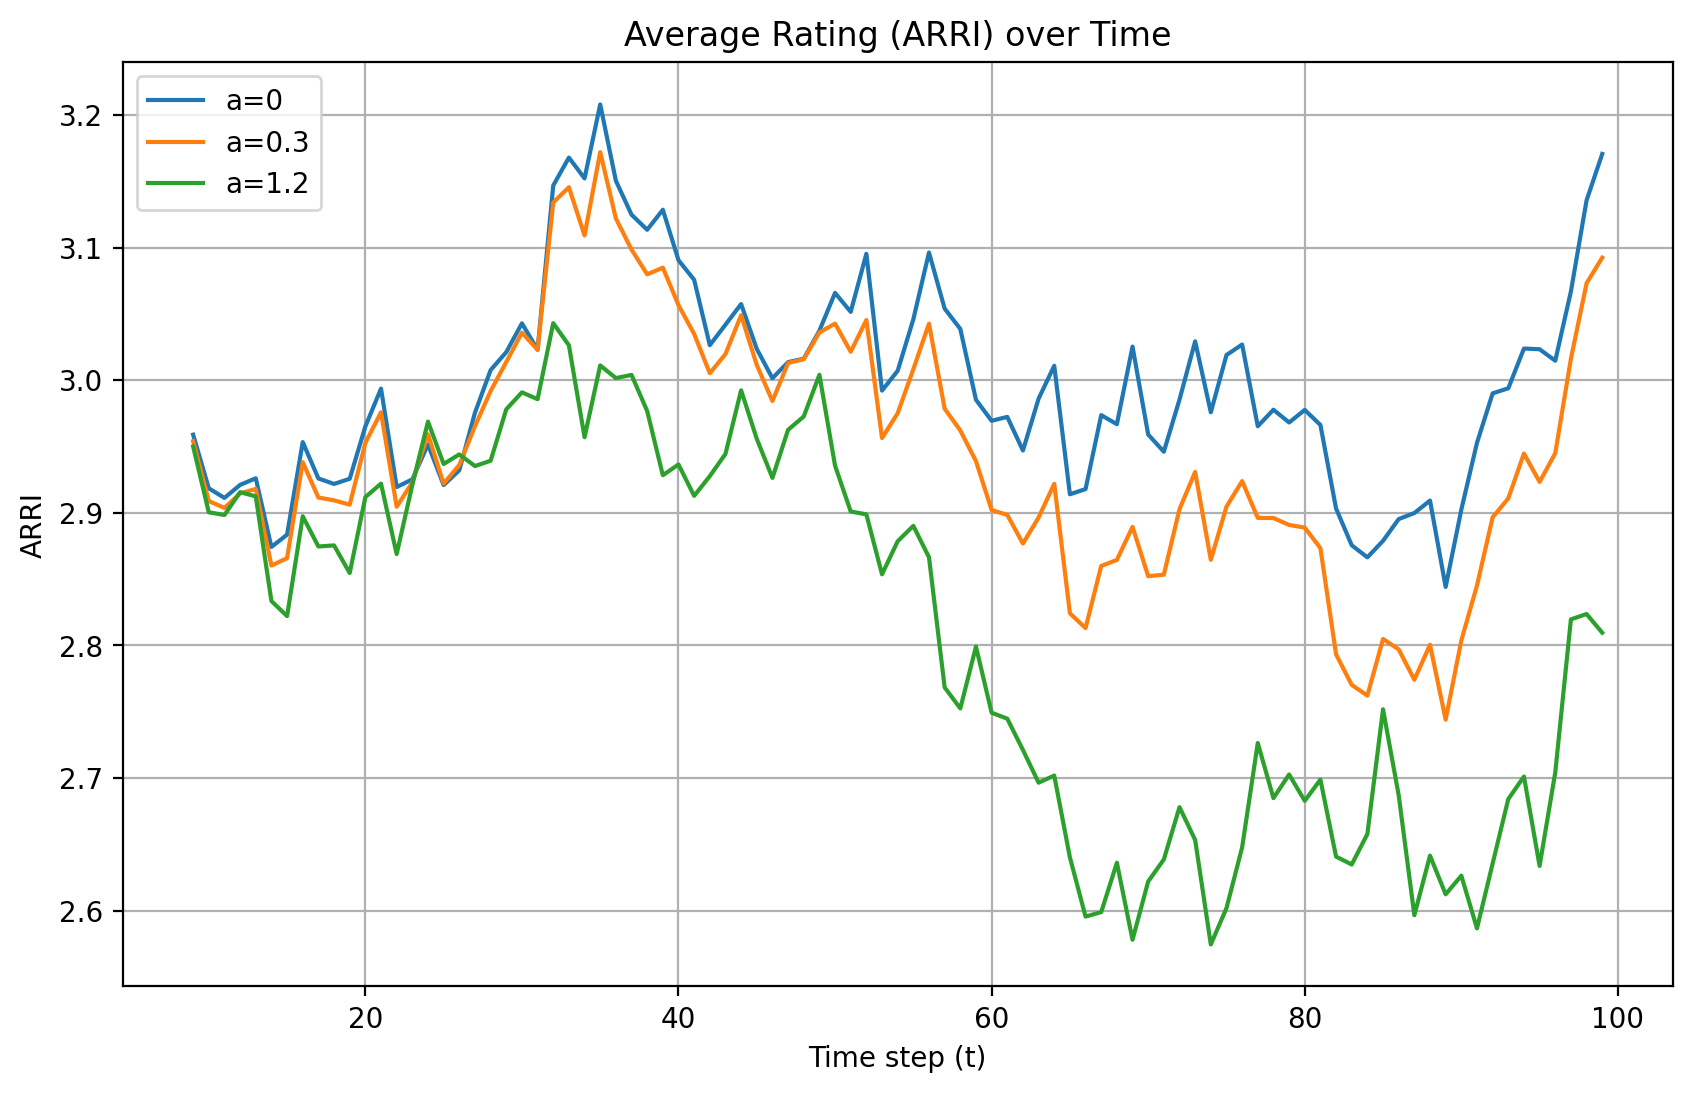

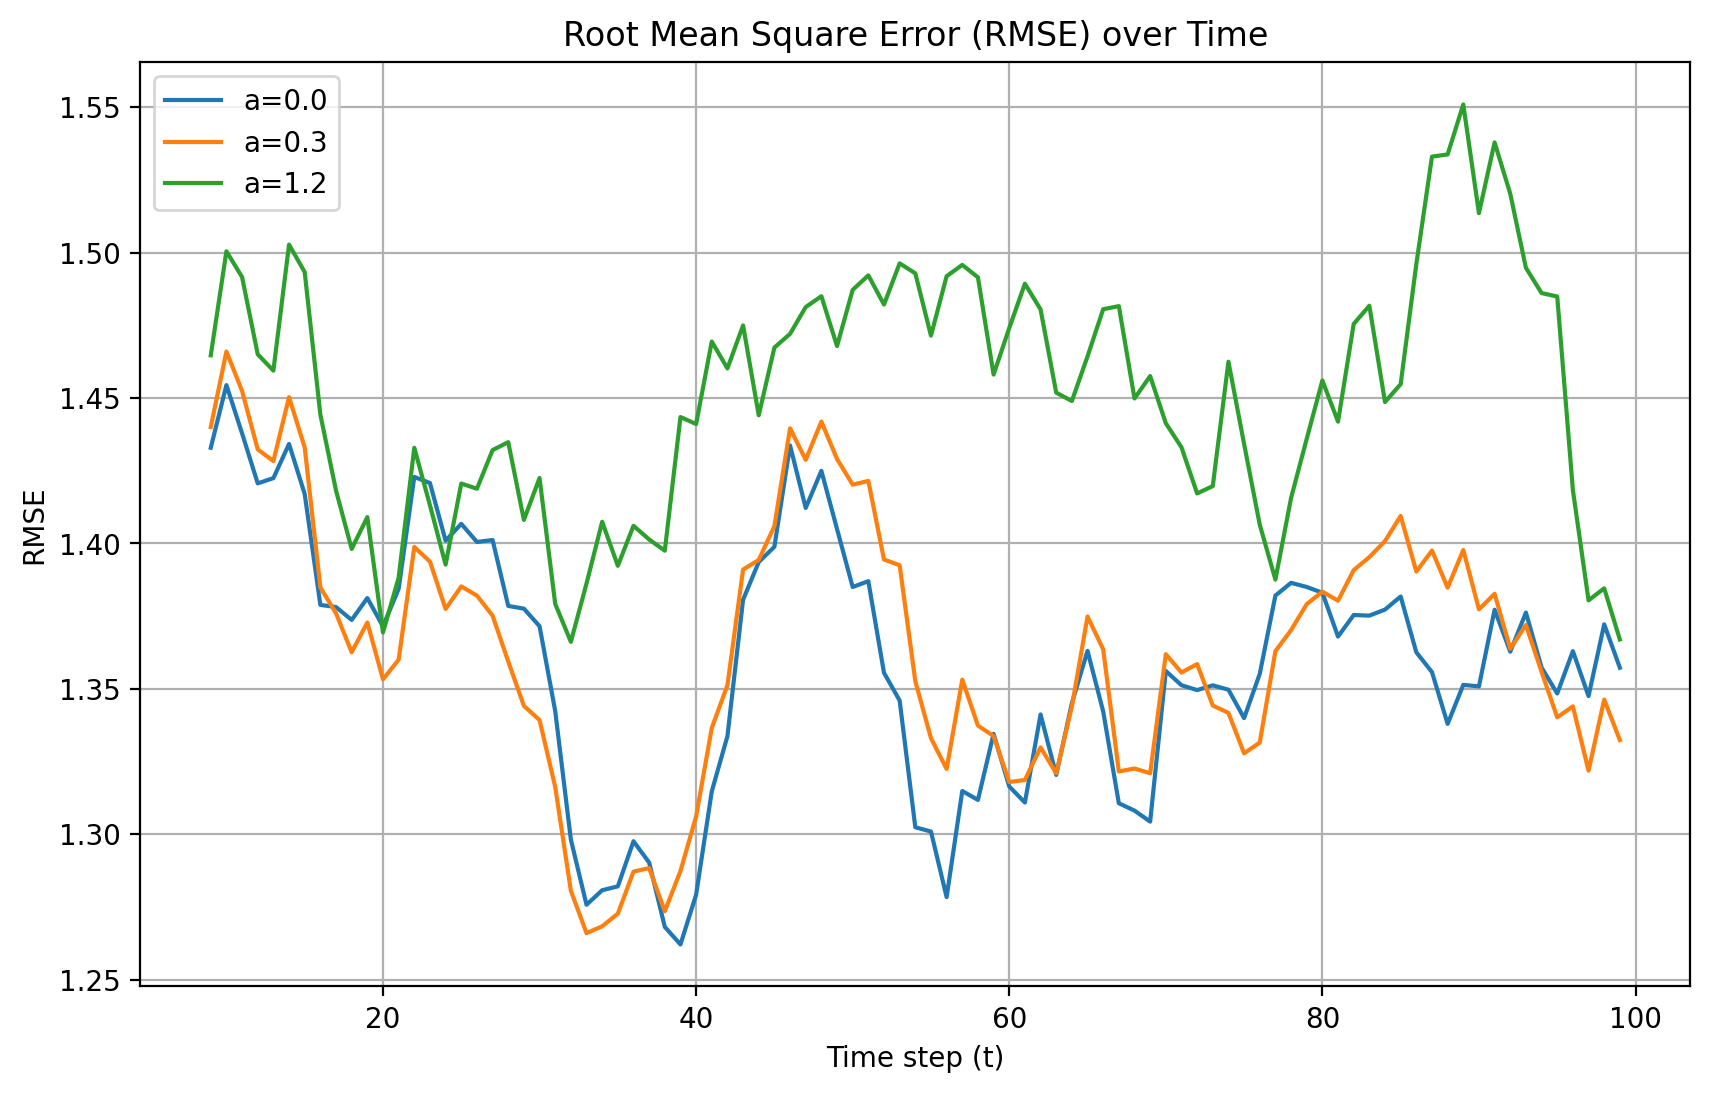

In [9]:
averaging_window_size = 10

## YOUR SOLUTION


plt.figure(figsize=(10, 6))
# Calculate RMSE and ARRI for each timestep
metrics_df = pd.DataFrame()
metrics_df['t'] = df['t'].unique()

# Calculate RMSE
rmse = df.groupby(['a', 't']).apply(lambda x: np.sqrt(((x['predicted_rating'] - x['actual_rating'])**2).mean())).reset_index()
rmse.columns = ['a', 't', 'rmse']

# Calculate ARRI (average actual rating)
arri = df.groupby(['a', 't'])['actual_rating'].mean().reset_index()
arri.columns = ['a', 't', 'arri']

# Merge metrics
metrics_df = pd.merge(rmse, arri, on=['a', 't'])

# Plot ARRI
plt.figure(figsize=(10, 6))
for a_val in a_values:
    data = metrics_df[metrics_df['a'] == a_val]
    plt.plot(data['t'], data['arri'].rolling(averaging_window_size).mean(), label=f'a={a_val}')

plt.xlabel('Time step (t)')
plt.ylabel('ARRI')
plt.title('Average Rating (ARRI) over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot RMSE 
plt.figure(figsize=(10, 6))
for a_val in df['a'].unique():
    data = metrics_df[metrics_df['a'] == a_val]
    plt.plot(data['t'], data['rmse'].rolling(averaging_window_size).mean(), label=f'a={a_val}')
    
plt.xlabel('Time step (t)')
plt.ylabel('RMSE')
plt.title('Root Mean Square Error (RMSE) over Time')
plt.legend()
plt.grid(True)
plt.show()


Explain the results. What do you observe in the graphs? In your answer, relate to:
* Overall trends in the plots.
* Are there values of $a$ for which RMSE/ARRI is significantly higher/lower? If so, why?

🔵 **Answer**:

The different values of $a$ don't seem to have a significant effect on the RMSE and ARRI.
This is likely because we only train once and then use the same model for the entire simulation.
Therefore, the model is not able to adapt to the changing user preferences over time, and so act the same way for all values of $a$.
The ratings of the users are affected by the value of $a$ but because the model does not adapt, the RMSE and ARRI are not affected (cancels out)

## Exercise 1.2: Retraining

Next, we will explore what happens when the recommender is retrained after, and compare this to the single training setting above.

Repeat the experiment described in the previous exercise, but this time, retrain the prediction model using all available predictions gathered from the environment so far (i.e initial ratings returned from `get_initial_ratings` + all ratings returned by the `recommend` method until the current time $t$).

Simulate two variations:
* **Retraining once**: Retrain the model once at the middle of the simulation (after $50$ simulation steps) using all available data, including initial observations.
* **Retraining every step**: Retrain the model after each simulation step using all data collected so far, including initial observations.

Use the simulation logic from Exercise 1.1.

For each variation, plot the RMSE and ARRI graphs for all three experimental conditions (the different values of $a$). Show all three of the RMSE lines the same plot, and all three of the ARRI lines on the same plot. Use rolling average with `window_size=10` to smooth results.

For the "retraining once" plots, mark the retraining point with the following command: `ax.axvline(retrain_after,color='tab:gray',linestyle=':',zorder=-1)`


🔵 **Solution**:

In [10]:
retrain_after = num_steps//2

## YOUR SOLUTION
a_values = [0, 0.3, 1.2]
num_steps = 100

np.random.seed(simulation_random_state)

def get_all_ratings(recommendations_recording, initial_ratings):
    ratings_df = pd.DataFrame(recommendations_recording, columns=['a', 't', 'user', 'item', 'predicted_rating', 'actual_rating', 'topic'])
    ratings_df = ratings_df[['user', 'item', 'actual_rating', 't']]
    ratings_df.columns = ['user', 'item', 'rating', 'timestamp']
    all_ratings = pd.concat([initial_ratings, ratings_df])
    return all_ratings

def simulation_with_retraining(a_values, num_steps, retrain_only_once=True):    
    recommendations_recording = []
    for a in a_values:
        env = TopicsDynamic(a=a, **topics_dynamic_params)
        initial_ratings = env.get_initial_ratings()
        all_items = env.all_items 
        algo = surprise.SVD(**svd_model_params)
        algo.fit(trainset_from_df(initial_ratings))
        for t in range(num_steps):
            if retrain_only_once and t == retrain_after:
                
                all_ratings = get_all_ratings(recommendations_recording, initial_ratings)
                algo.fit(trainset_from_df(all_ratings))
            elif not retrain_only_once and t != 0: # We don't need to retrain at the first step
                all_ratings = get_all_ratings(recommendations_recording, initial_ratings)
                algo.fit(trainset_from_df(all_ratings))
            # Get online users for this timestep
            online_users = env.get_online_users()
            
            # Get recommendations for each online user
            predictions = [
                max([algo.predict(user, item) for item in all_items if item not in env.seen_items[user]], key=lambda x: x.est)
                for user in online_users
            ]
            recommendations = [(pred.uid, pred.iid) for pred in predictions]
            
            user_ratings_df = env.recommend(recommendations)
            
            recommendations_recording.extend([
                (a, t, user, item, pred.est, user_ratings_df.loc[user_ratings_df['user_id']==user, 'rating'].values[0], env._get_latent_topic(item))
                for (user, item), pred in zip(recommendations, predictions)
            ])
            
    df = pd.DataFrame(recommendations_recording)
    df.columns = ['a', 't', 'user', 'item', 'predicted_rating', 'actual_rating', 'topic']
    return df



In [11]:
df_retraining_once = simulation_with_retraining(a_values, num_steps, retrain_only_once=True)

In [12]:
df_retraining_every_step = simulation_with_retraining(a_values, num_steps, retrain_only_once=False)

In [13]:
def plot_metrics(df, should_retrain_once=True): 
    plt.figure(figsize=(10, 6))
    # Calculate RMSE and ARRI for each timestep
    metrics_df = pd.DataFrame()
    metrics_df['t'] = df['t'].unique()

    # Calculate RMSE
    rmse = df.groupby(['a', 't']).apply(lambda x: np.sqrt(((x['predicted_rating'] - x['actual_rating'])**2).mean())).reset_index()
    rmse.columns = ['a', 't', 'rmse']

    # Calculate ARRI (average actual rating)
    arri = df.groupby(['a', 't'])['actual_rating'].mean().reset_index()
    arri.columns = ['a', 't', 'arri']

    # Merge metrics
    metrics_df = pd.merge(rmse, arri, on=['a', 't'])

    # Plot ARRI
    plt.figure(figsize=(10, 6))
    for a_val in df['a'].unique():
        data = metrics_df[metrics_df['a'] == a_val]
        plt.plot(data['t'], data['arri'].rolling(averaging_window_size).mean(), label=f'a={a_val}')
        if should_retrain_once:
            plt.axvline(retrain_after,color='tab:gray',linestyle=':',zorder=-1)

    plt.xlabel('Time step (t)')
    plt.ylabel('ARRI')
    plt.title('Average Rating (ARRI) over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot RMSE 
    plt.figure(figsize=(10, 6))
    for a_val in df['a'].unique():
        data = metrics_df[metrics_df['a'] == a_val]
        plt.plot(data['t'], data['rmse'].rolling(averaging_window_size).mean(), label=f'a={a_val}')
        if should_retrain_once:
            plt.axvline(retrain_after,color='tab:gray',linestyle=':',zorder=-1)
        
    plt.xlabel('Time step (t)')
    plt.ylabel('RMSE')
    plt.title('Root Mean Square Error (RMSE) over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

<Figure size 1000x600 with 0 Axes>

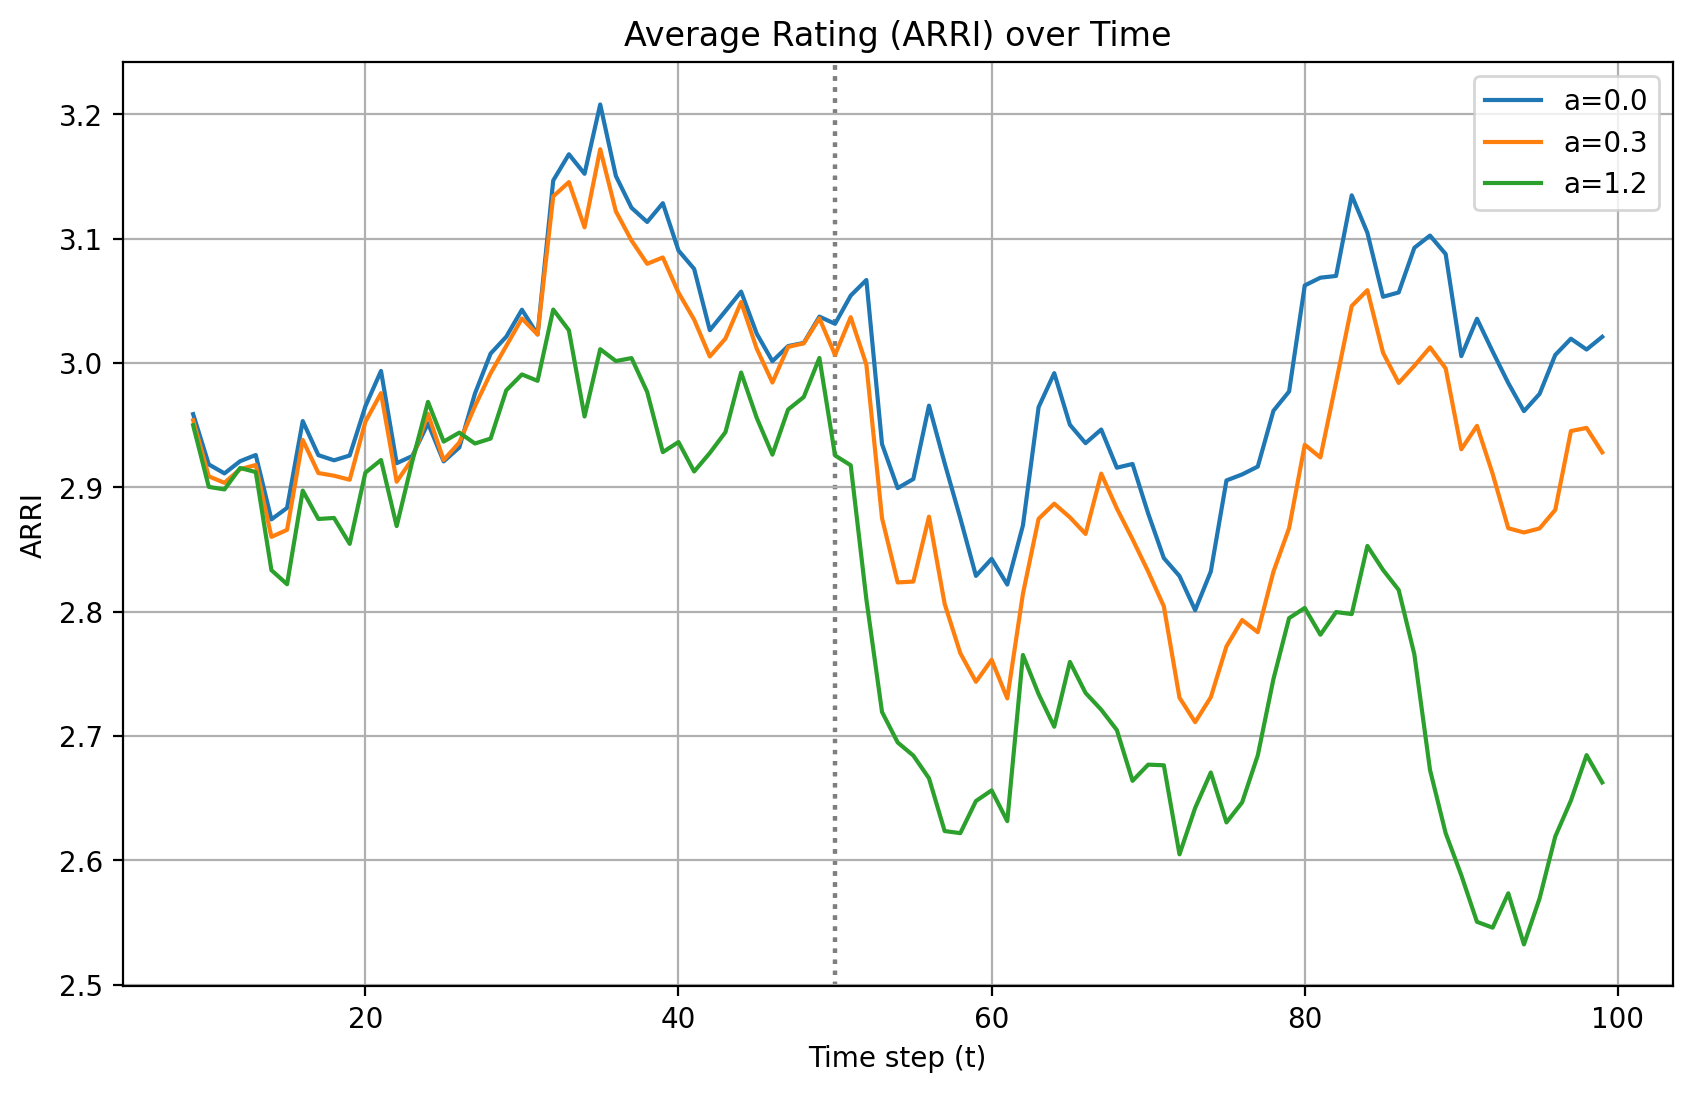

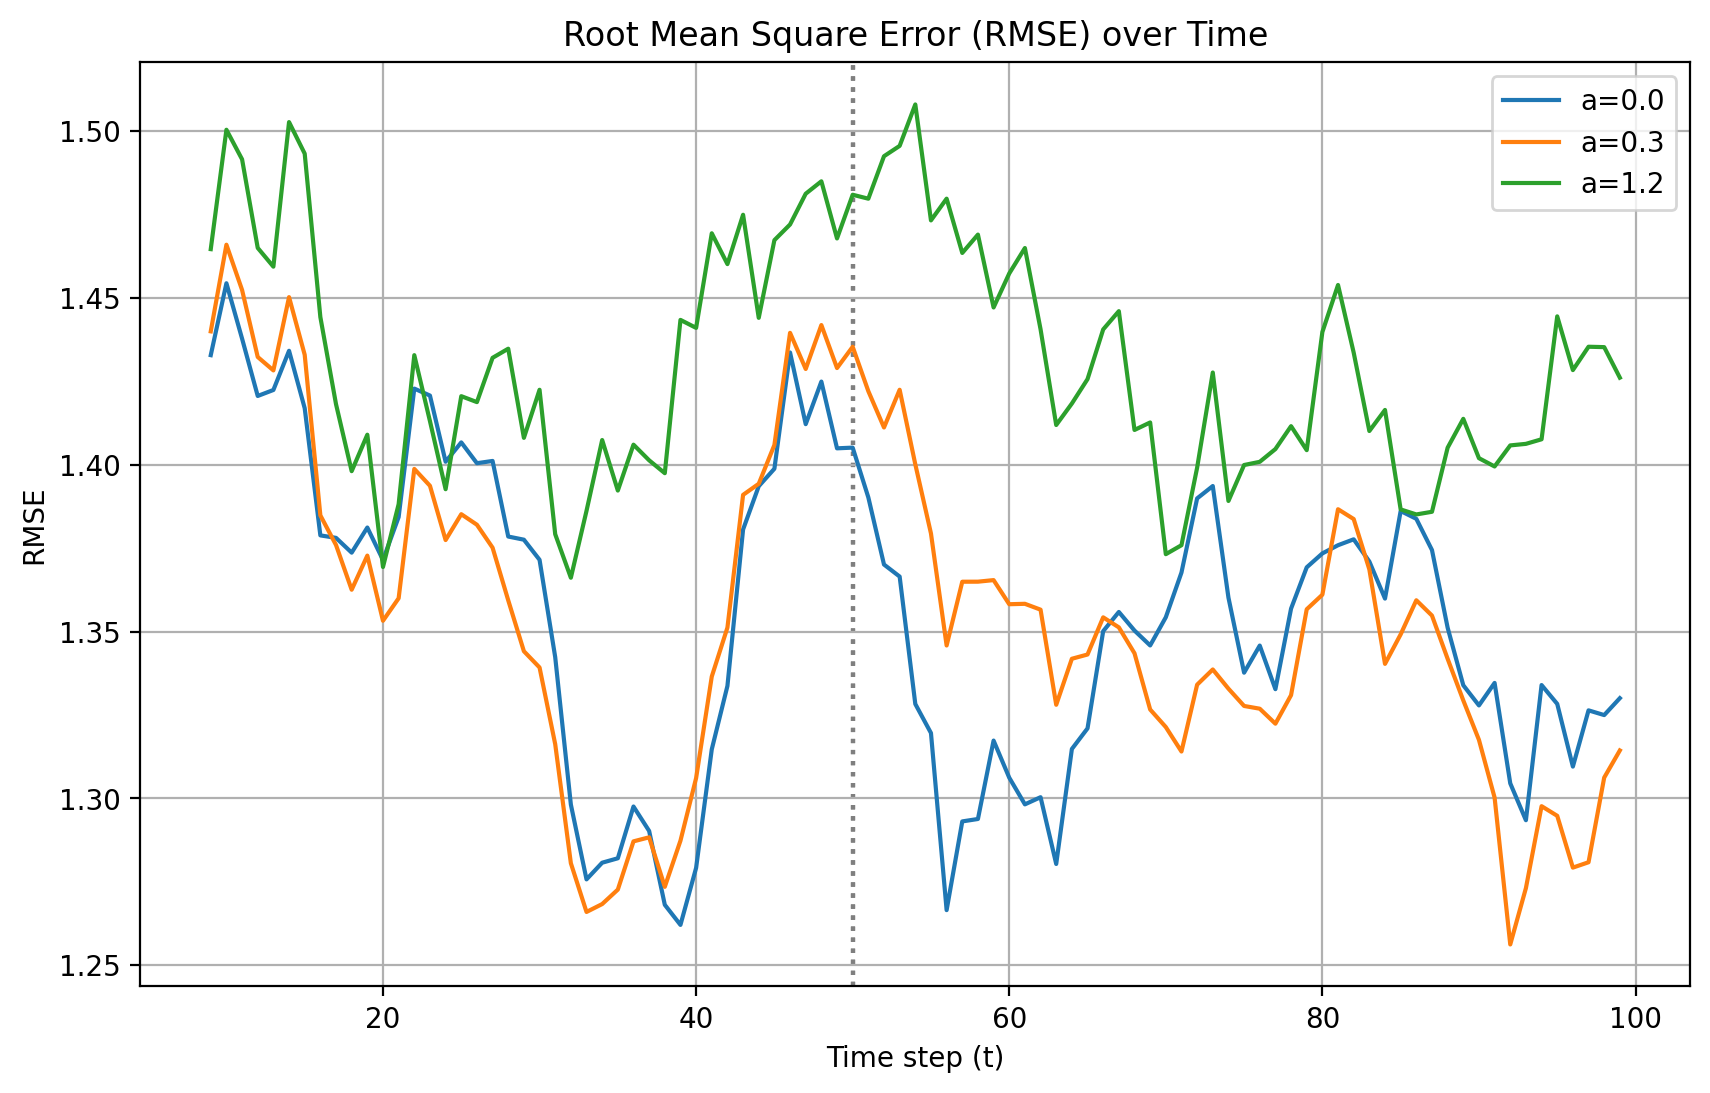

In [14]:
plot_metrics(df_retraining_once, should_retrain_once=True)

<Figure size 1000x600 with 0 Axes>

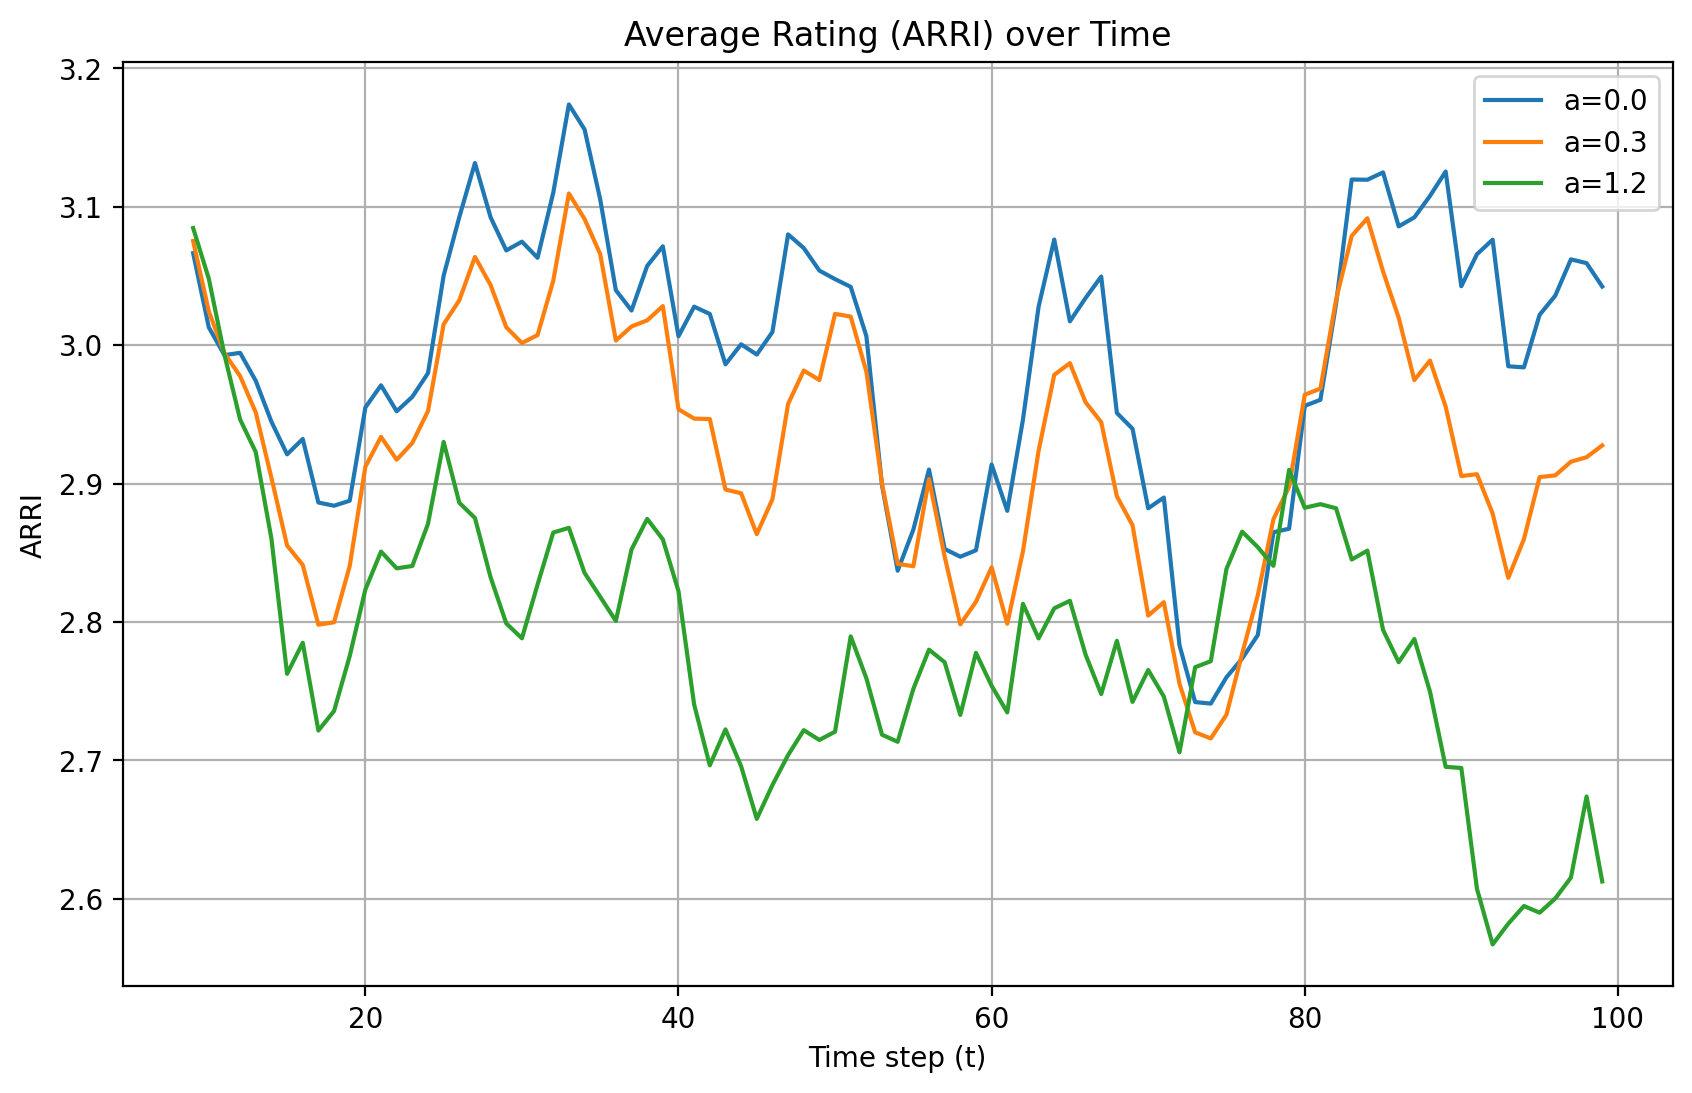

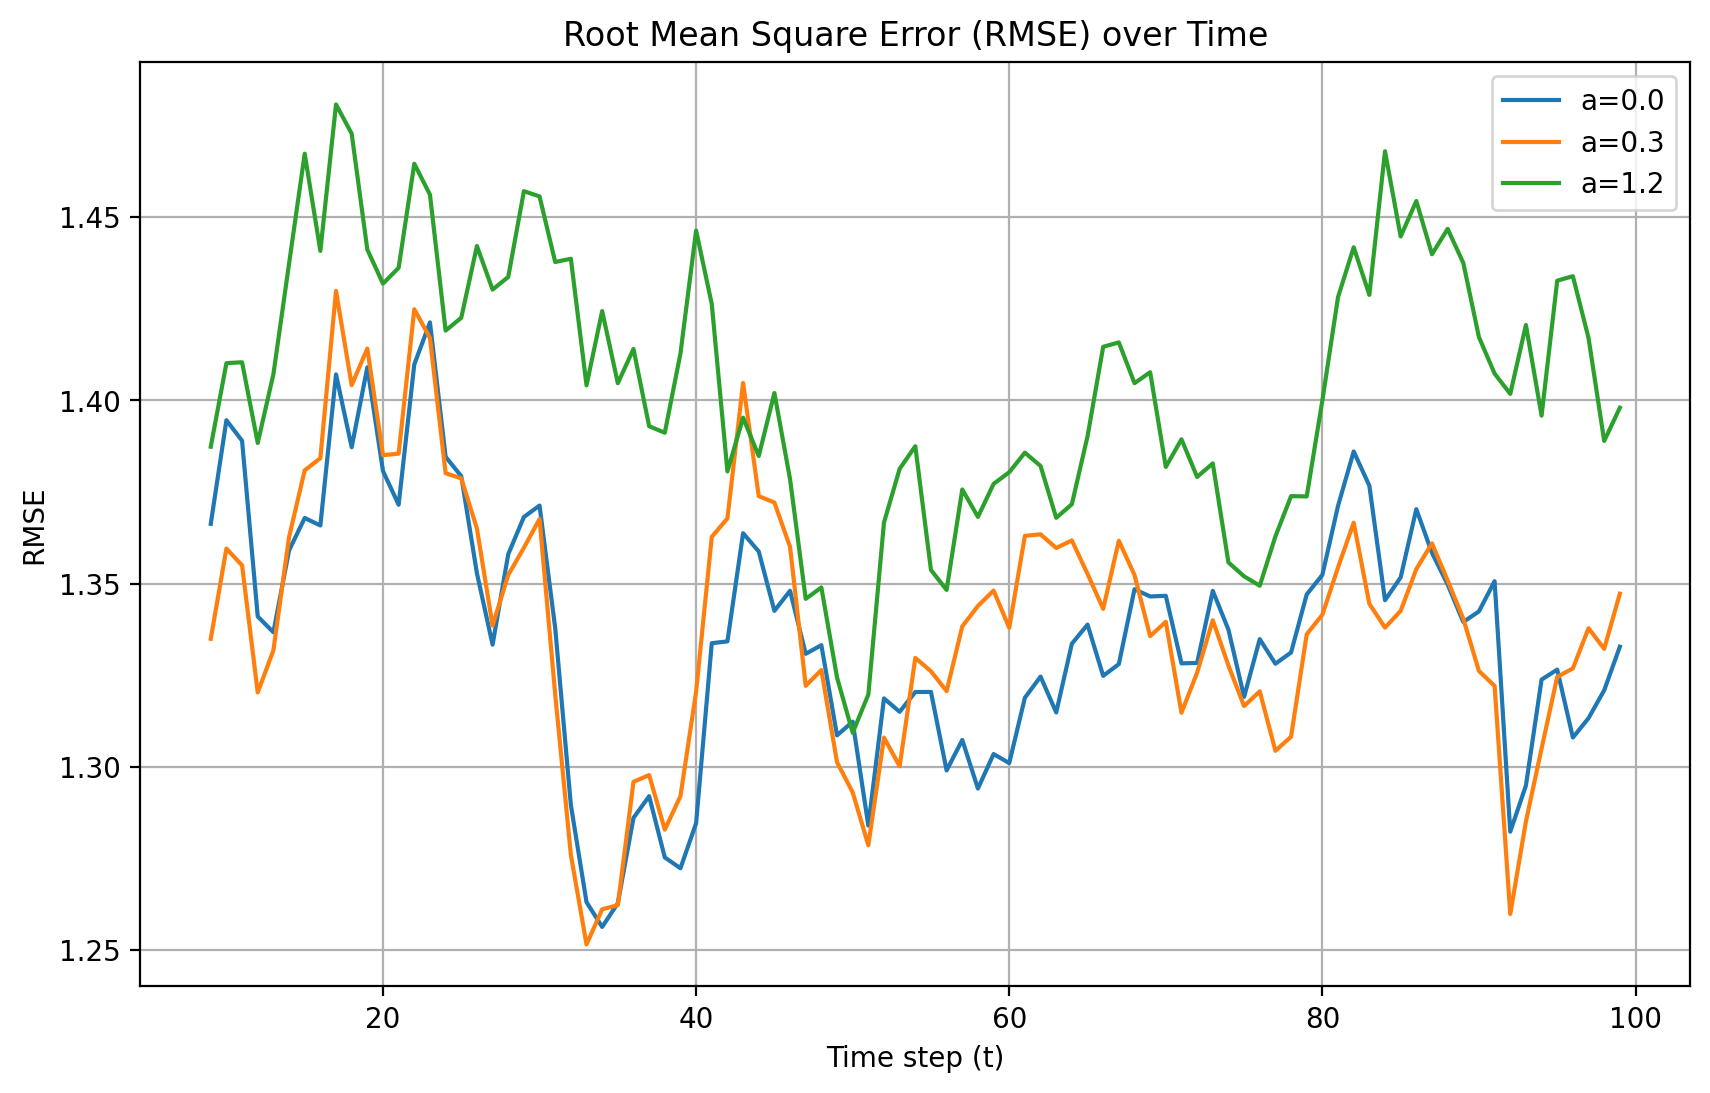

In [15]:
plot_metrics(df_retraining_every_step, should_retrain_once=False)

Interpret your results.

What do you observe in the graphs?

🔵 **Answer**:

(YOUR SOLUTION)

## Exercise 1.3: Aggregate comparison
Analyze your results from the previous exercises.

For a given simulation run, the average ARRI is defined as:

$$
\bar{\mathrm{ARRI}} =
\frac{
    \sum_{t=1}^T
    \sum_{u\in U_t}
    r_t (u, x_u)
}{
    \sum_{t=1}^T |U_t|
}
$$

and the average RMSE is defined as:

$$
\bar{\mathrm{RMSE}} = \left(
\frac{
    \sum_{t=1}^T
    \sum_{u\in U_t}
    \left(\hat{r}_t (u, x_u) - r_t (u, x_u) \right)^2
}{
    \sum_{t=1}^T |U_t|
}
\right)^{0.5}
$$


Create a bar plot that compares retraining vs. not retraining in terms of **RMSE** for each $a$ value and experiment variation. Is there a general trend? Explain.

🔵 **Answer**:

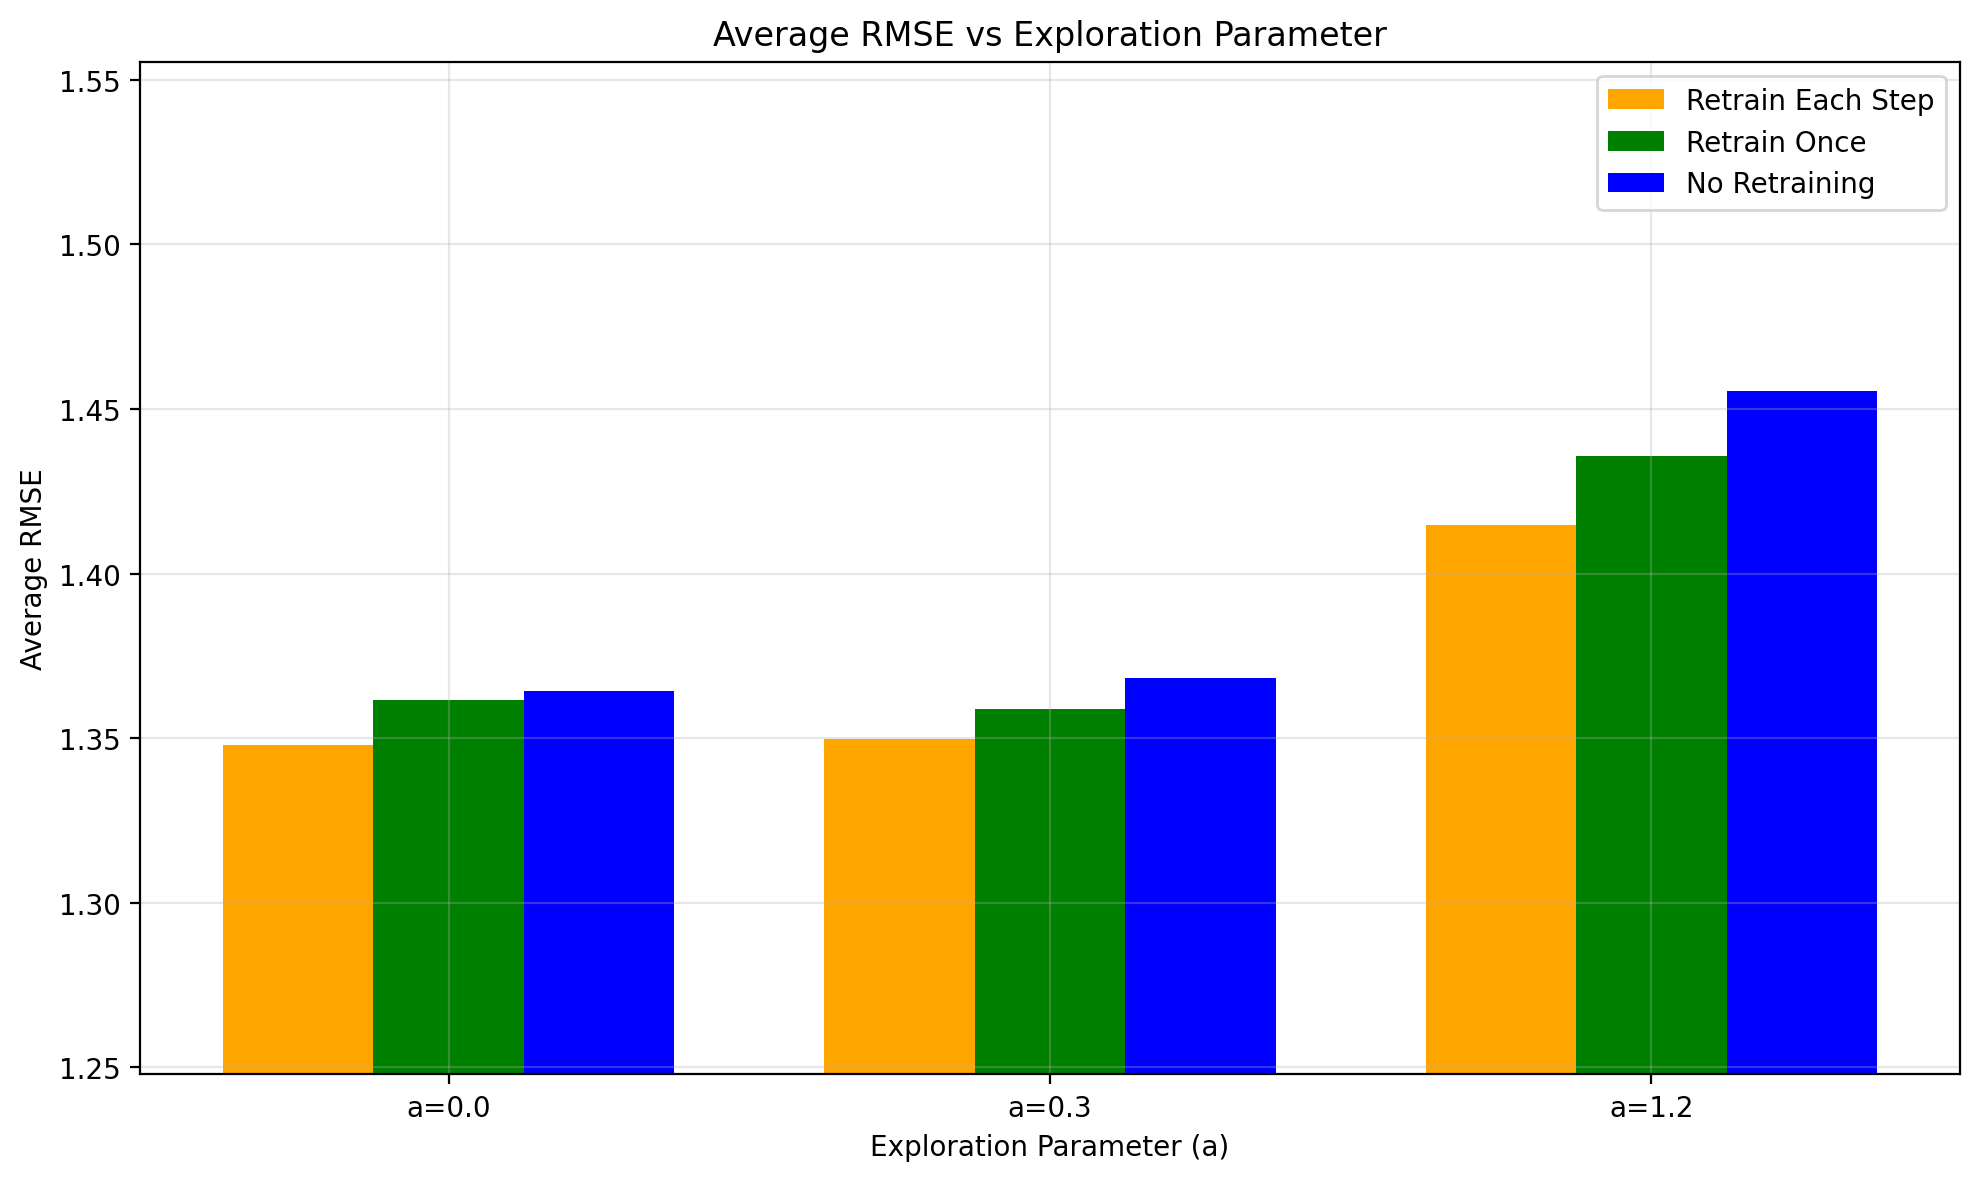

In [16]:
## YOUR SOLUTION
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure
plt.figure(figsize=(10, 6))

# Get unique a values and sort them
a_values = sorted(df_retraining_every_step['a'].unique())

# Calculate average RMSE for each a value and retrain condition
rmse_data = []
for a in a_values:
    # Get data for this a value
    mask_every_step = df_retraining_every_step['a'] == a
    mask_once = df_retraining_once['a'] == a
    mask_df = df['a'] == a
    
    # Calculate RMSE for each condition
    rmse_retrain_each = np.sqrt(np.mean((df_retraining_every_step[mask_every_step]['predicted_rating'] - df_retraining_every_step[mask_every_step]['actual_rating'])**2))
    rmse_retrain_once = np.sqrt(np.mean((df_retraining_once[mask_once]['predicted_rating'] - df_retraining_once[mask_once]['actual_rating'])**2))
    rmse_df = np.sqrt(np.mean((df[mask_df]['predicted_rating'] - df[mask_df]['actual_rating'])**2))
    
    rmse_data.append([rmse_retrain_each, rmse_retrain_once, rmse_df])

# Set up bar positions
x = np.arange(len(a_values))
width = 0.25  # Reduced width to fit 3 bars

# Create bars
plt.bar(x - width, [d[0] for d in rmse_data], width, label='Retrain Each Step', color='orange')
plt.bar(x, [d[1] for d in rmse_data], width, label='Retrain Once', color='green')
plt.bar(x + width, [d[2] for d in rmse_data], width, label='No Retraining', color='blue')

# Customize plot
plt.xlabel('Exploration Parameter (a)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs Exploration Parameter')
plt.xticks(x, [f'a={a}' for a in a_values])
plt.legend()

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Calculate y-axis limits based on data range
all_values = [val for sublist in rmse_data for val in sublist]
y_min = min(all_values) - 0.1
y_max = max(all_values) + 0.1
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()


🔵 **Explain your results**:

(YOUR SOLUTION)

Now, create a plot that compares training vs. not training in terms of **ARRI** for each $a$ value (use your results from exercises 1.1.1 and 1.1.2). Is there a general trend? Explain.

🔵 **Answer**:

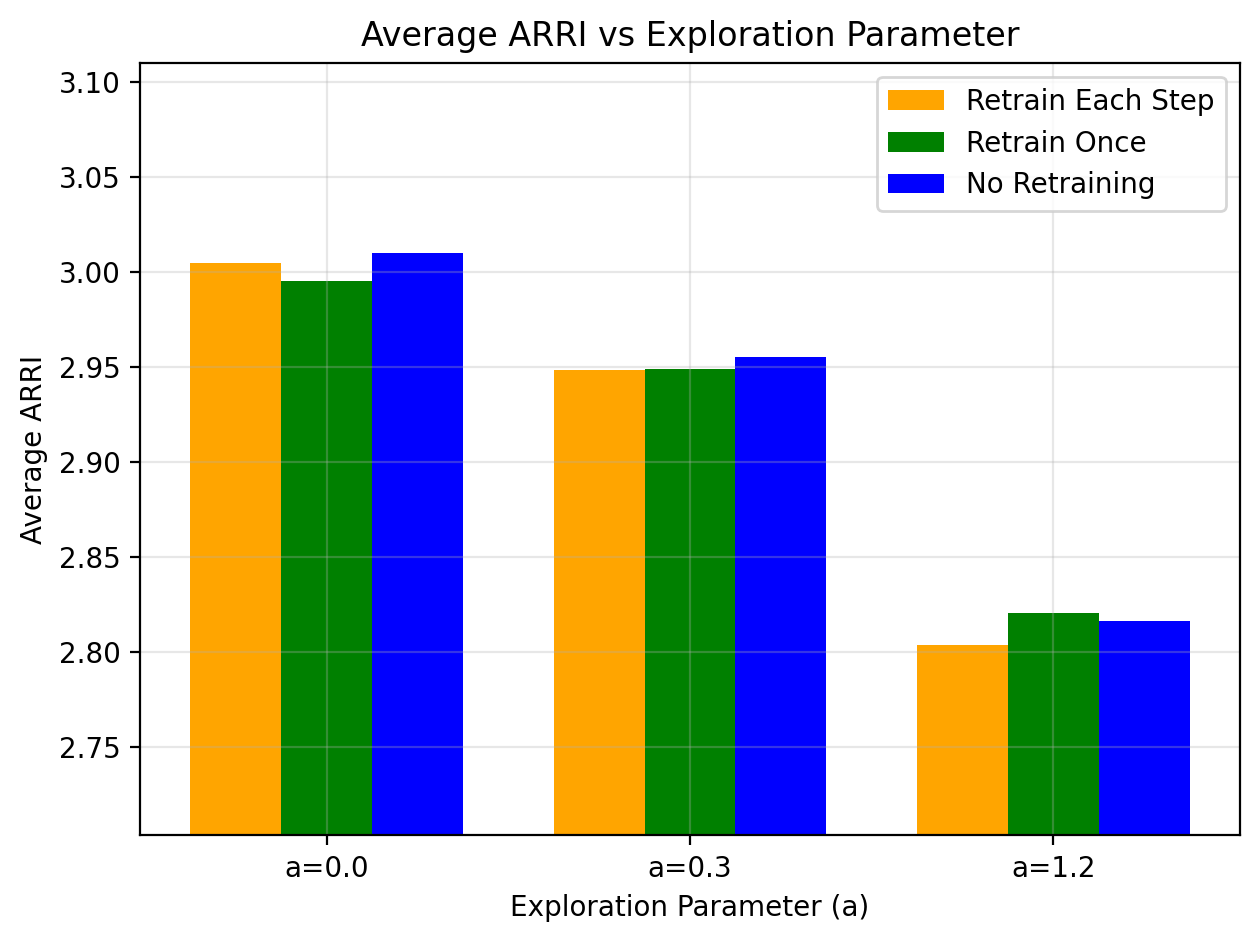

In [17]:
## YOUR SOLUTION
# Initialize lists to store ARRI data
arri_data = []

# Calculate average ARRI for each a value
for a in a_values:
    # Get data for this a value
    mask_every_step = df_retraining_every_step['a'] == a
    mask_once = df_retraining_once['a'] == a
    mask_df = df['a'] == a
    
    # Calculate average ARRI for each condition
    arri_retrain_each = df_retraining_every_step[mask_every_step]['actual_rating'].mean()
    arri_retrain_once = df_retraining_once[mask_once]['actual_rating'].mean()
    arri_df = df[mask_df]['actual_rating'].mean()
    
    arri_data.append([arri_retrain_each, arri_retrain_once, arri_df])

# Set up bar positions
x = np.arange(len(a_values))
width = 0.25  # Reduced width to fit 3 bars

# Create bars
plt.bar(x - width, [d[0] for d in arri_data], width, label='Retrain Each Step', color='orange')
plt.bar(x, [d[1] for d in arri_data], width, label='Retrain Once', color='green')
plt.bar(x + width, [d[2] for d in arri_data], width, label='No Retraining', color='blue')

# Customize plot
plt.xlabel('Exploration Parameter (a)')
plt.ylabel('Average ARRI')
plt.title('Average ARRI vs Exploration Parameter')
plt.xticks(x, [f'a={a}' for a in a_values])
plt.legend()

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Calculate y-axis limits based on data range
all_values = [val for sublist in arri_data for val in sublist]
y_min = min(all_values) - 0.1
y_max = max(all_values) + 0.1
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()


🔵 **Explain your results**:

(YOUR SOLUTION)

## Exercise 1.4: Analyzing diversity

For a user $u$ being shown $n_u$ items throughout the simulation run, denote by $k_i\in[K]$ the topic of the item shown to the user on their $i$-th interaction with the system.

The *empirical topic distribution* for user $u$ is the [empirical distribution](https://en.wikipedia.org/wiki/Empirical_distribution_function) of topics shown to $u$ throughout the simulation run:

$$
p_u(k)
= \frac{\sum_{i=1}^{n_u} \mathbb{I}[k_i=k]}{n_u}
$$



### 1.4.1: Entropy

The [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) of a discrete random variable defined as:

$$
H(p) = -\sum_k p(k) \log_2 p(k)
$$

The entropy is a property of the random variable given by $p$:
* Entropy is maximized when the probability is uniform (i.e. each query of the random variable returns a value with uniform probability over outcomes)
* Entropy minimized when the random variable is a singleton (i.e. each query returns the same value)


Implement the function `shannon_entropy(lst)` which receives a list of integers and returns the Shannon entropy of their empirical distribution.

🔵 **Solution**:

In [18]:
## YOUR SOLUTION
def shannon_entropy(lst):
    # Get empirical distribution by counting occurrences and dividing by length
    counts = {x: lst.count(x) for x in set(lst)}
    
    # Calculate probabilities
    probs = {k: v/len(lst) for k,v in counts.items()}
    
    # Print the probability distribution
    print(probs)
    
    # Calculate entropy using formula: -sum(p * log2(p))
    entropy = 0
    for p_k in probs.values():
        entropy -= p_k * np.log2(p_k)
        
    return entropy




For each variation of the experiment (retraining: none/once/every step, different values of $a$), calculate the topic entropy for each user using the formula above. Create a bar plot comparing the average entropy for each variation.

🔵 **Solution**:

{0: 0.23529411764705882, 1: 0.4117647058823529, 2: 0.17647058823529413, 3: 0.17647058823529413}
{0: 0.2222222222222222, 1: 0.3333333333333333, 2: 0.25925925925925924, 3: 0.18518518518518517}
{0: 0.19047619047619047, 1: 0.2857142857142857, 2: 0.23809523809523808, 3: 0.2857142857142857}
{0: 0.22727272727272727, 1: 0.3181818181818182, 2: 0.2727272727272727, 3: 0.18181818181818182}
{0: 0.21739130434782608, 1: 0.34782608695652173, 2: 0.2608695652173913, 3: 0.17391304347826086}
{0: 0.22727272727272727, 1: 0.36363636363636365, 2: 0.22727272727272727, 3: 0.18181818181818182}
{0: 0.25, 1: 0.3, 2: 0.3, 3: 0.15}
{0: 0.3333333333333333, 1: 0.3333333333333333, 2: 0.06666666666666667, 3: 0.26666666666666666}
{0: 0.29411764705882354, 1: 0.29411764705882354, 2: 0.17647058823529413, 3: 0.23529411764705882}
{0: 0.24, 1: 0.32, 2: 0.28, 3: 0.16}
{0: 0.16666666666666666, 1: 0.3333333333333333, 2: 0.25, 3: 0.25}
{0: 0.2608695652173913, 1: 0.30434782608695654, 2: 0.2608695652173913, 3: 0.17391304347826086}
{

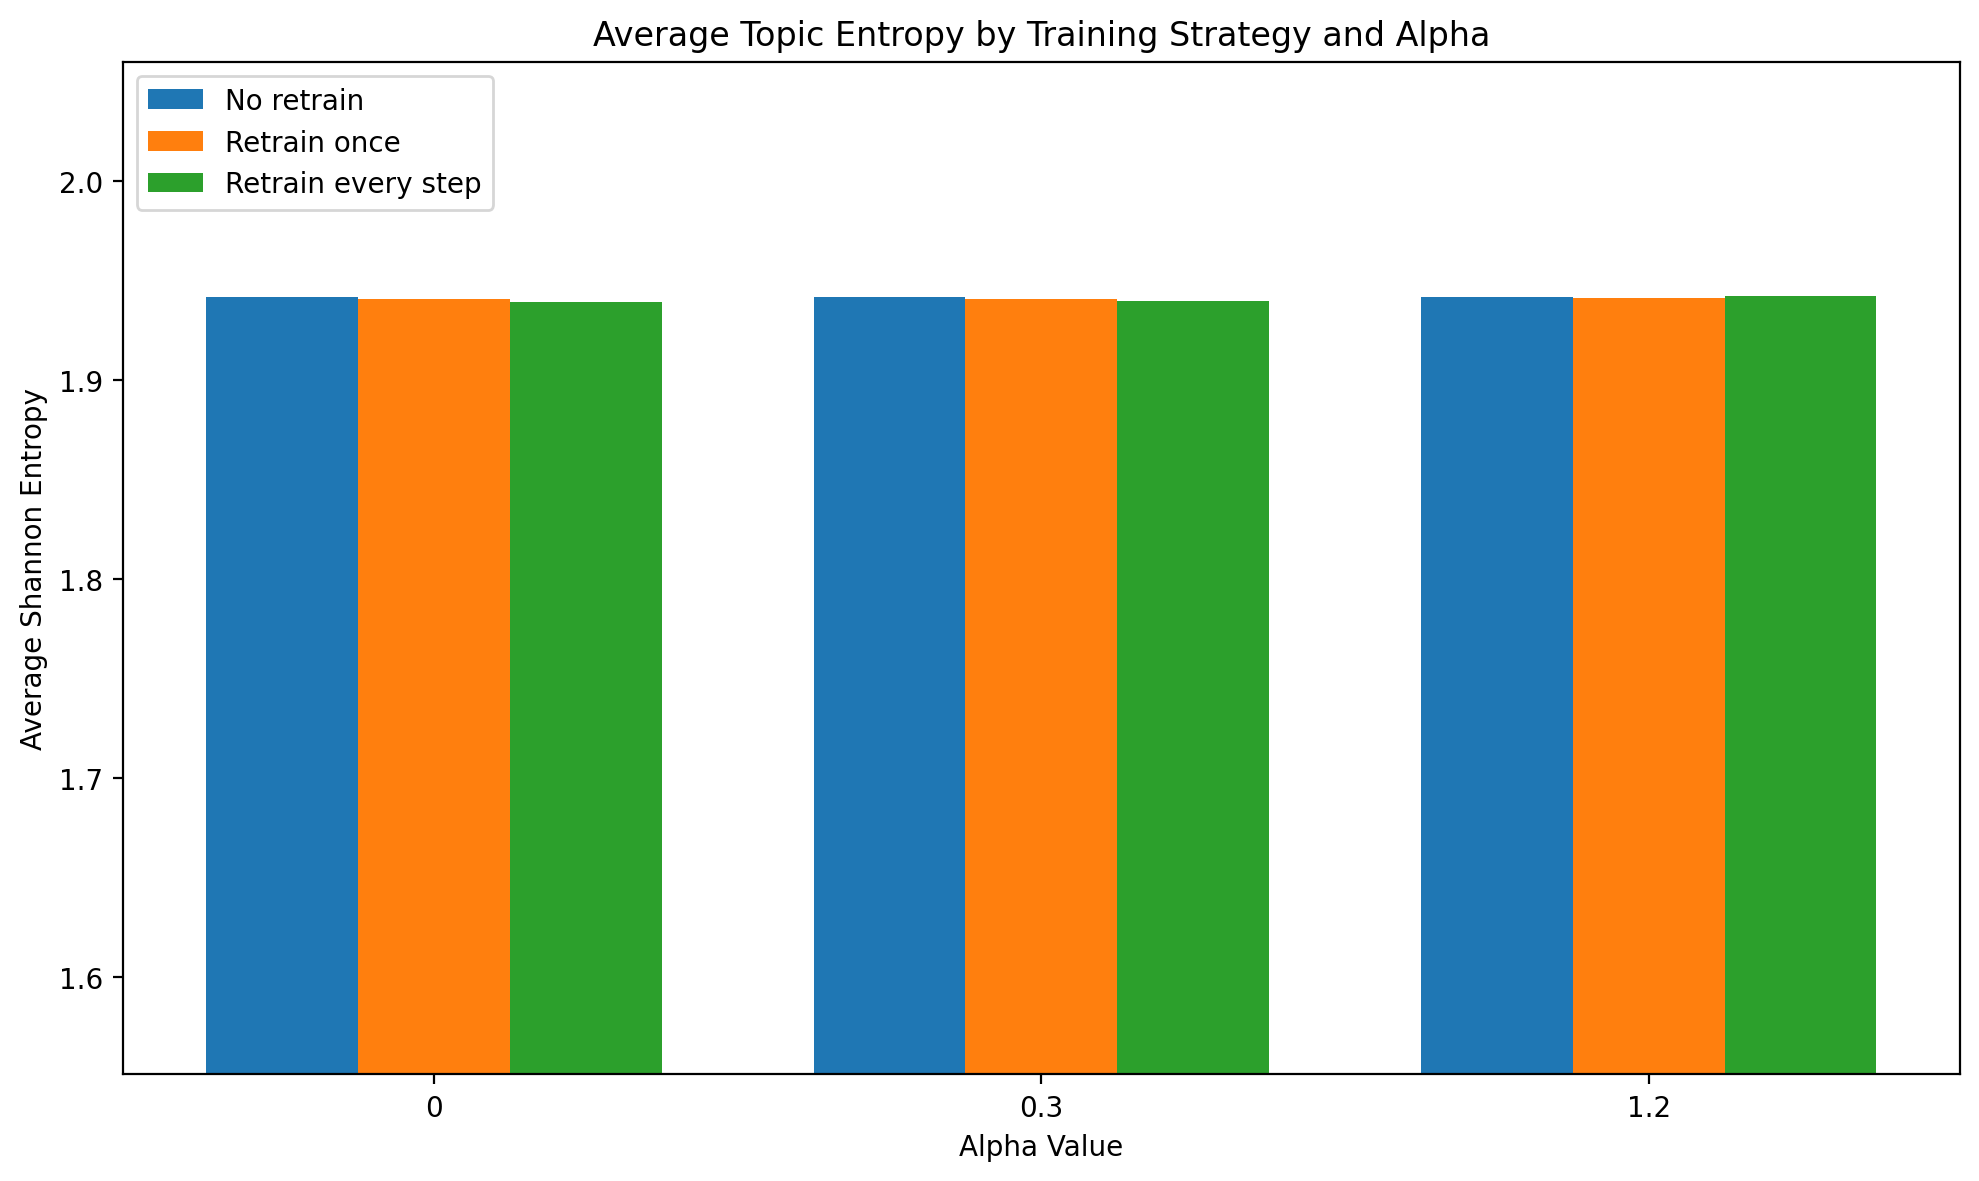

In [19]:
## YOUR SOLUTION
# Calculate entropy for each user in each experiment variation
def get_user_entropies(df):
    user_entropies = {}
    for user in df['user'].unique():
        user_topics = df[df['user'] == user]['topic'].tolist()
        user_entropies[user] = shannon_entropy(user_topics)
    return user_entropies

# Get average entropy for each experiment variation and alpha value
alphas = [0, 0.3, 1.2]
datasets = [df, df_retraining_once, df_retraining_every_step]
labels = ['No retrain', 'Retrain once', 'Retrain every step']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Different color for each dataset

plt.figure(figsize=(10, 6))

x = np.arange(len(alphas))
width = 0.25  # Width of bars
multiplier = 0

for dataset, label, color in zip(datasets, labels, colors):
    avg_entropies = []
    for alpha in alphas:
        df_var = dataset[dataset['a'] == alpha]
        user_entropies = get_user_entropies(df_var)
        print(f"User entropies for alpha={alpha}:", user_entropies)
        avg_entropy = np.mean(list(user_entropies.values()))
        avg_entropies.append(avg_entropy)
    
    offset = width * multiplier
    plt.bar(x + offset, avg_entropies, width, label=label, color=color)
    multiplier += 1

# Customize plot
plt.title('Average Topic Entropy by Training Strategy and Alpha')
plt.xlabel('Alpha Value')
plt.ylabel('Average Shannon Entropy')
plt.xticks(x + width, alphas)
plt.legend(loc='upper left')

# Focus y-axis on area of difference
ymin = min([min(get_user_entropies(d[d['a'].isin(alphas)]).values()) for d in datasets]) * 1
ymax = max([max(get_user_entropies(d[d['a'].isin(alphas)]).values()) for d in datasets]) * 1.03
plt.ylim(ymin, ymax)

plt.tight_layout()


# Print the average entropy values for each combination
# print("\nAverage Topic Entropy Values:")
# print("-" * 50)
# for dataset, label in zip(datasets, labels):
#     print(f"\n{label}:")
#     for alpha in alphas:
#         df_var = dataset[dataset['a'] == alpha]
#         user_entropies = get_user_entropies(df_var)
#         avg_entropy = np.mean(list(user_entropies.values()))
#         print(f"Alpha {alpha}: {avg_entropy:.4f}")

plt.show()




Explain your results:

🔵 **Answer**:

For the no retraining case, we can see that the alpha values are all the same, and the entropy is the same for all of them.
This is to be expected. The reason is that the entropy is a measure of how diverse our suggestions to the user are.
The alpha value only affects the preference of the user from the second step on, because it is affected by what the user has already seen.
Because we are not retraining, the model only trains once on the initial_ratings that are not affected by the alpha value.
And so, different alpha values will not affect the model's predictions, and so the entropy will be the same.

For the retraining once case, we can see that the entropy is higher for the alpha values that are closer to 0.
This is because the model is retrained once, and so for higher alpha values, the new model is more likely to recommend items that are similar to the ones that the user has already seen.
This results in a lower entropy, because the model is more likely to recommend the same item to the user.

For the retraining every step case, we can see a similar trend to the retraining once case.
The entropy is higher for the alpha values that are closer to 0.
This is because the model is retrained every step, and so the new model is more likely to recommend items that are different from the ones that the user has already seen.
This results in a higher entropy, because the model is more likely to recommend different items to the user.


### 1.4.2: Trade-off?

Is there a trade-off between diversity and item rating?

Create a scatter plot to visualize the relation between average topic entropy and average item rating for each experiment variation. Make sure that each point in the scatterplot is annotated appropriately using text or shape/color. You can annotate points using the matplotlib [`ax.annotate(...)`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html) function.

🔵 **Solution**:

{0: 0.23529411764705882, 1: 0.4117647058823529, 2: 0.17647058823529413, 3: 0.17647058823529413}
{0: 0.2222222222222222, 1: 0.3333333333333333, 2: 0.25925925925925924, 3: 0.18518518518518517}
{0: 0.19047619047619047, 1: 0.2857142857142857, 2: 0.23809523809523808, 3: 0.2857142857142857}
{0: 0.22727272727272727, 1: 0.3181818181818182, 2: 0.2727272727272727, 3: 0.18181818181818182}
{0: 0.21739130434782608, 1: 0.34782608695652173, 2: 0.2608695652173913, 3: 0.17391304347826086}
{0: 0.22727272727272727, 1: 0.36363636363636365, 2: 0.22727272727272727, 3: 0.18181818181818182}
{0: 0.25, 1: 0.3, 2: 0.3, 3: 0.15}
{0: 0.3333333333333333, 1: 0.3333333333333333, 2: 0.06666666666666667, 3: 0.26666666666666666}
{0: 0.29411764705882354, 1: 0.29411764705882354, 2: 0.17647058823529413, 3: 0.23529411764705882}
{0: 0.24, 1: 0.32, 2: 0.28, 3: 0.16}
{0: 0.16666666666666666, 1: 0.3333333333333333, 2: 0.25, 3: 0.25}
{0: 0.2608695652173913, 1: 0.30434782608695654, 2: 0.2608695652173913, 3: 0.17391304347826086}
{

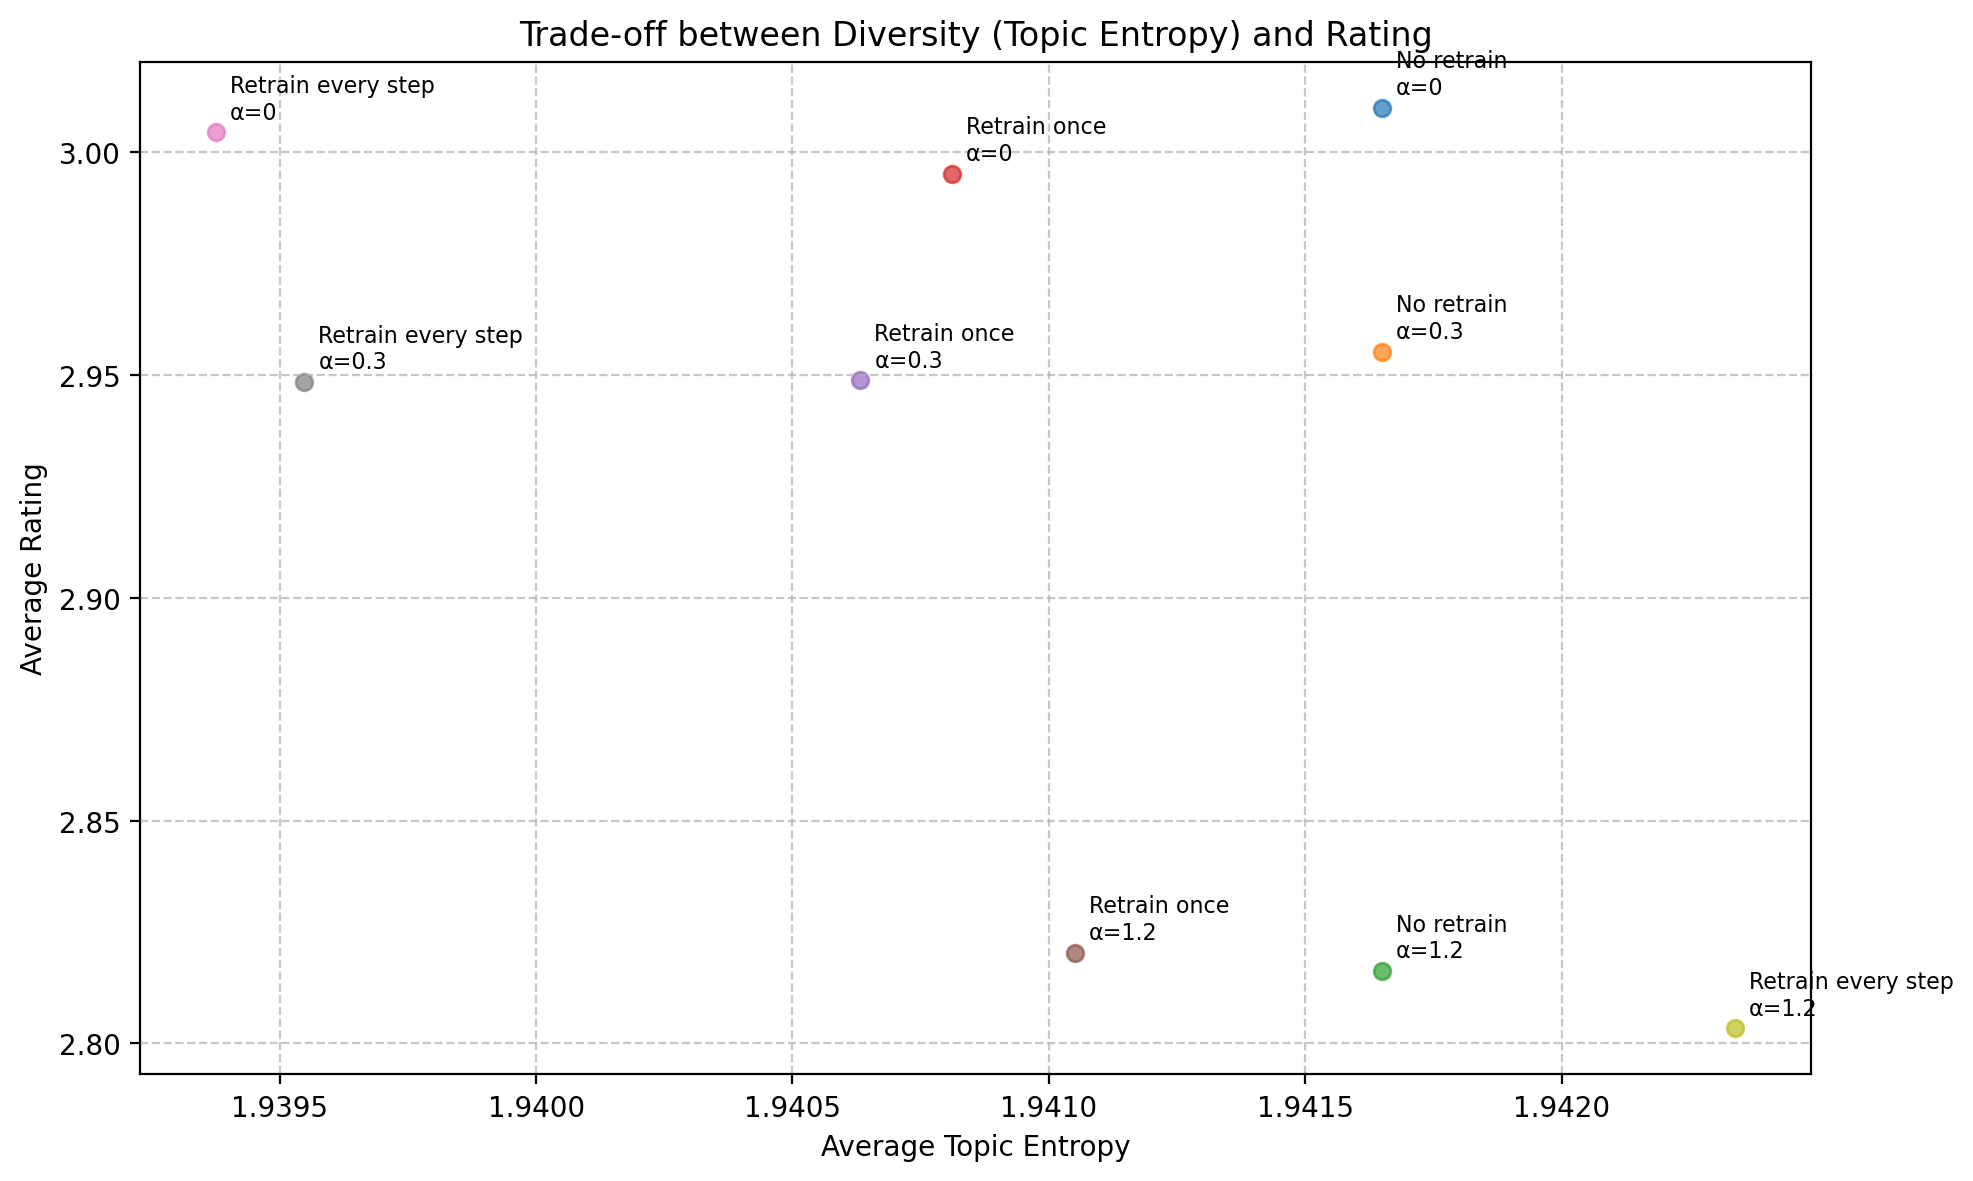

In [20]:
## YOUR SOLUTION
# Create a figure
plt.figure(figsize=(10, 6))

# For each experiment type (no retrain, retrain once, retrain every step)
for label, df in zip(labels, datasets):
    # For each alpha value
    for alpha in alphas:
        df_var = df[df['a'] == alpha]
        
        # Calculate average entropy
        user_entropies = get_user_entropies(df_var)
        avg_entropy = np.mean(list(user_entropies.values()))
        
        # Calculate average rating
        avg_rating = df_var['actual_rating'].mean()
        
        # Plot point and annotate
        plt.scatter(avg_entropy, avg_rating, alpha=0.7)
        plt.annotate(f'{label}\nα={alpha}', 
                    (avg_entropy, avg_rating),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=8)

plt.xlabel('Average Topic Entropy')
plt.ylabel('Average Rating')
plt.title('Trade-off between Diversity (Topic Entropy) and Rating')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()


Explain your results. Is there a trade-off? What do you conclude about the relation between diversity and average rating?

🔵 **Answer**:

(YOUR SOLUTION)

## Exercise 1.5: Thinking about experimentation
Above, we experimented with an ideal setting where we could compare different retraining scenarios side by side. From this, we were able to draw conclusions about the effects of retraining.
In the real-world, however, we can only choose one retraining policy at any given time, and any evaluation method has caveats.

Let's assume a slightly more realistic setting where you only have access to the data from the "retrain once" simulation in Exercise 1.2, and your goal is to measure the change in the ARRI metric as a result of retraining.

Two initial solutions have been proposed:
1. Measure ARRI at the step before retraining, and compare to the ARRI at the step after retraining.
2. Measure ARRI 10 steps before retraining, and compare to the average ARRI 10 steps after retraining.

Given these proposed solutions, answer the following questions:


What are the the advantages and disadvantages of each approach?

🔵 **Answer**:

(YOUR SOLUTION)
The first approach is simple and easy to implement. It is also easy to understand and interpret because it is a simple comparison between two steps.
The disadvantage is that it is not very accurate, because it only looks at the rating at the step before retraining and after retraining, but not an average of more steps.

The second approach is more accurate, because it looks at an average of more steps.
The disadvantage is that it is more complex to implement, and it is not easy to understand and interpret, a change in the retraining might also be hidden when looking at an average of more steps.


Are there limitations which are common to both approaches?

🔵 **Answer**:

Both steps don't take into account what are the real ratings of the users as opposed to the predicted ratings.
And so, a user might in general have higher ratings as time go on, and we might see a change in the ARRI metric after a retraining, even if the retraining did not affect the model's predictions.
For example, in an enviorment where the users are more likely to rate items higher after s/he has seen items of the same topic, without lowering the ratings of items of other topics, then the user will have a higher average ratings over time, and so ARRI will increase even if the retraining did not affect the model's predictions.



How would you measure the change in ARRI as a result of retraining? What are the limitations of your approach?

🔵 **Answer**:

(YOUR SOLUTION)


# Part 2: Fighting feedback using one-step “lookahead”

## Introduction

This section is **exploratory** - you are encouraged to think, experiment, and try out different approaches. Concentrate on thinking things through and proposing a sound idea (worry more about what you propose, and less about whether it works exactly as expected or not). **Be creative!**

As we've seen so far in this workshop, recommendation is a dynamic process that is prone to feedback effects, due both to the actions of the system (e.g., retraining) and the behavioral tendencies of users (e.g., preference change with exposure, susceptibility to social signals). Feedback can sometimes help, but at other times - can promote undesired outcomes, either in terms of performance (predictive or recommendation qulity) or other important aspects (homogenization, echo chambers, filter bubbles, etc.).

Ideally, learning to recommend should be done in a way that takes feedback into account and optimizes various criteria for the *long term*. However, this is an exceptionally challenging task. One milder alternative is to instead use a greedy approach and recommend in a way that considers the effects of recommendation only **one time-step ahead**.

The idea here is for the system--*before* it recommends--to simulate how users are likely to act in response to recommendations. By "looking ahead" one step into the future, and by anticipating user responses, the system can in principal be smarter about what it plans to recommend, ideally in a way that compensates for any possible negative affects.

In reallity, the system must "guess" how users will act in the next timestep. In this exercise, we will make life easier for you, and allow you to use the simulation environment itself to simulate what will happen next. This will focus the challenge on planning ahead correctly (rather than on estimating user responses). Technically, do this using ``copy.deepcopy(env)`` - this copies the environment and lets you perform a simulated step on it, without affecting the natural flow of the simulation itself.

Restrictions: In this exercise, we assume that the environment can be cloned, but in practical scenarios we don't have complete knowledge about the environment, and therefore the structure of the environment can only be estimated, and at relatively high cost. Therefore, in your solution you should assume that the environment can only be cloned once (or a few times) for every time step. In addition, you may only interact with the environment through its public interface (e.g. `env.recommend`), and may not assume knowledge of the environment's latent parameters  (e.g. you are not allowed to use `env._get_latent_topic`).


Example for using `copy.deepcopy`:

In [21]:
# Initialize environment
example_env = TopicsDynamic(a=0.5, **topics_dynamic_params)

# Copy it using deepcopy
import copy
example_env_copy = copy.deepcopy(example_env)

# Get a random list of online users from the original and the copy
example_online_users = example_env.get_online_users()
example_online_users_copy = example_env_copy.get_online_users()

# Lists of online users should be identical
assert (example_online_users==example_online_users_copy).all()

# You are allowed to use example_env_copy.recommend(...) to probe how
# users will react, and use this to inform your recommendation policy.

## Step 2.1: Choose your problem

**Plan ahead!** Begin by deciding what *negative effect* of prediction-only recommendation you wish to combat using a lookahead strategy. This could be one of the effects we've discussed above (predictive performance, ratings/welfare, homogenization/diversity, popularity/fat-tails, echo-chambers), mentioned in class (filter bubbles, polarization), or something else (ask us!).

Then, define an environment and recommendation policy that you feel are appropriate for working with the effect you've chosen. Think carefully about what properties these should have for you to (i) observe the effect, and (ii) be able to mitigate it.

Finally, determine how you will need to extend the existing simulation your experimental setup. For example, you may need to control user preferences, update stored data, expose latent features, or (re)train the model in certain ways.

🔵 **Write these down**:

* **Chosen effect**: Polarization and homogenization in user preferences

* **Environment**: TopicsDynamic with a=1

* **Recommendation policy**: SVD with a multi-armed approach that considers both ratings and polarization

* **Simulation**: Run for 100 steps, comparing our multi-armed lookahead strategy against a baseline SVD recommender



🔵 **Briefly explain your choices**:

We chose these parameters because:
1. A moderate a=1 allows enough preference drift to observe polarization effects without being too extreme
2. SVD is effective for rating prediction while being computationally efficient enough to support multiple lookahead simulations, also it is the recommendation system that we used in the previous part of the workshop
3. The multi-armed approach with 4 candidates balances exploration of different recommendation sets with computational feasibility.

## Step 2.2: State your lookahead strategy

Imagine the system has just received a new batch of data, retrained on it, and is about to send recommendations to its users. What is "good" about these recomendations, and what can be "bad"? If the system had the ability to anticipate what would happen *after* it recommends - would it change its recommendations, and how?

Decide on a lookahead strategy - briefly explain:
* What do you plan to look ahead for?
* How will you do this? (remember you can "cheat" by using a copy of the simulation environment)
* What will you be looking for and what you will measure?
* How will you use this to change your recommendations?

🔵 **Answer**:

Lookahead Strategy:
1. Initial Recommendations:
    - For each user, get top 2k items based on predicted ratings
    - Generate 4 different recommendation sets by sampling/permuting from these items
2. Simulation for Each Candidate Set:
    - Use deepcopy to simulate recommending those items
    - Observe actual ratings received
    - Retrain the model with these new ratings
3. Polarization Analysis:
    - Calculate polarization score by:
      * Getting predicted ratings for all items
      * Computing distance between items ratings distribution and uniform ratings distribution
      * Lower distance = less polarization = better score
4. Final Selection:
    - Compute weighted score: w1 * rating_score + w2 * (1/polarization_score)
    - Select recommendation set with highest final score
    - This balances immediate user satisfaction with diversity preservation


## Step 2.3: Research question

Phrase your intentions as a **research question**.

Ideally, a research question is **concise**, **testable**, and has a **simple answer** that we still don't know.

Your research question should refer to the "problem variables" that you modify, and the "result" you expect to measure.

🔵 **Answer**:

"Can a multi-armed lookahead strategy that optimizes for both rating performance and topic diversity reduce recommendation polarization while maintaining satisfactory rating performance compared to a standard SVD recommender?"
This question is:
* Concise: Focuses on specific strategy and metrics
* Testable: We can measure both polarization and rating performance
* Novel: Combines multi-armed selection with lookahead for dual optimization

## Step 2.4: Implement and analyze
Create a new simulation flow (similar to the simulation flow in Part 1), which simulates a recommendation system and its affect on the environment.
Implement within this function your lookahead step.

Run an experiment that compares a your lookahead approach to a myopic baseline (that does not lookahead). Think carefully about how to set up the environment and dynamics, what to measure, and how.

Plot your results, and discuss them. You are encouraged to use multiple code cells to separate between the different stages of simulation and analysis (possibly with Markdown cells between them expaining the process).

🔵 **Answer**:

In [31]:
class DiversityAwareSVDRecommender4:
    def __init__(self, n_candidates=5, rating_weight=0.5, diversity_weight=0.5):
        self.n_candidates = n_candidates
        self.rating_weight = rating_weight
        self.diversity_weight = diversity_weight
        self.algo = surprise.SVD(**svd_model_params)
        self.all_ratings = None
        
    def fit(self, ratings_df):
        self.all_ratings = ratings_df
        self.algo.fit(trainset_from_df(ratings_df))
    
    def calculate_polarization_score_for_each_user(self, env_copy, online_users):
        # Calculate average polarization score across all online users
        users_polarization_scores = {}
        for user_id in online_users:
            # Get predictions for all available items
            available_items = [item for item in env_copy.all_items 
                             if item not in env_copy.seen_items[user_id]]
            predictions = [self.algo.predict(user_id, item).est 
                         for item in available_items]
            
            #  we define polarizations as the number of items rated as 1 or 5 over the total number of items rated
            # print('predictions', predictions)
            total_extremes = sum(1 for p in predictions if p < 1.5 or p > 4.5)
            # print('total_extremes', total_extremes)
            users_polarization_scores[user_id] = total_extremes / len(available_items)
        return users_polarization_scores
    
    def get_candidate_recommendations(self, online_users, env):
        # Generate 4 different recommendation sets for all users
        candidates = []
        for candidate_index in range(self.n_candidates):
            recommendations = []
            for user_id in online_users:
                available_items = [item for item in env.all_items 
                                 if item not in env.seen_items[user_id]]
                
                predictions = [(item, self.algo.predict(user_id, item).est) 
                             for item in available_items]
                top_item = sorted(predictions, key=lambda x: x[1], reverse=True)[candidate_index]
                recommendations.append((user_id, top_item[0]))
                
            candidates.append(recommendations)
        return candidates
    
    def calculate_polarization_score(self, env_copy, online_users):
        # Calculate average polarization score across all online users
        users_polarization_scores = self.calculate_polarization_score_for_each_user(env_copy, online_users)
        return np.mean(list(users_polarization_scores.values()))
    
    
    def recommend(self, env, online_users):
        # Get 4 different candidate recommendation sets
        candidates = self.get_candidate_recommendations(online_users, env)
        best_score = float('-inf')
        best_recommendations = None
        
        # Create a dictionary to store user recommendations and scores
        user_recommendations = {user_id: {} for user_id in online_users}
        
        # Evaluate each candidate set
        for candidate_index, candidate in enumerate(candidates):
            env_copy = copy.deepcopy(env)
            
            # Simulate recommendations
            ratings_df = env_copy.recommend(candidate)
            
            # Retrain and calculate polarization for each user
            self.fit(pd.concat([self.all_ratings, ratings_df]))
            users_polarization_scores = self.calculate_polarization_score_for_each_user(env_copy, online_users)
            
            # Store ratings and polarization scores for each user-item pair
            for row in ratings_df.itertuples():
                user_id, item_id, rating = row.user_id, row.item_id, row.rating
                user_recommendations[user_id][item_id] = (rating, users_polarization_scores[user_id])
        
        # Select best item for each user based on weighted scores
        best_recommendations = []
        for user_id in online_users:
            best_score = float('-inf')
            best_item = None
            
            for item_id, (rating, polarity) in user_recommendations[user_id].items():
                normalized_rating = (rating - 1) / 4
                total_score = (self.rating_weight * normalized_rating + 
                             self.diversity_weight * (1 - polarity))
                if total_score > best_score:
                    best_score = total_score
                    best_item = item_id
                    
            best_recommendations.append((user_id, best_item))
        return best_recommendations

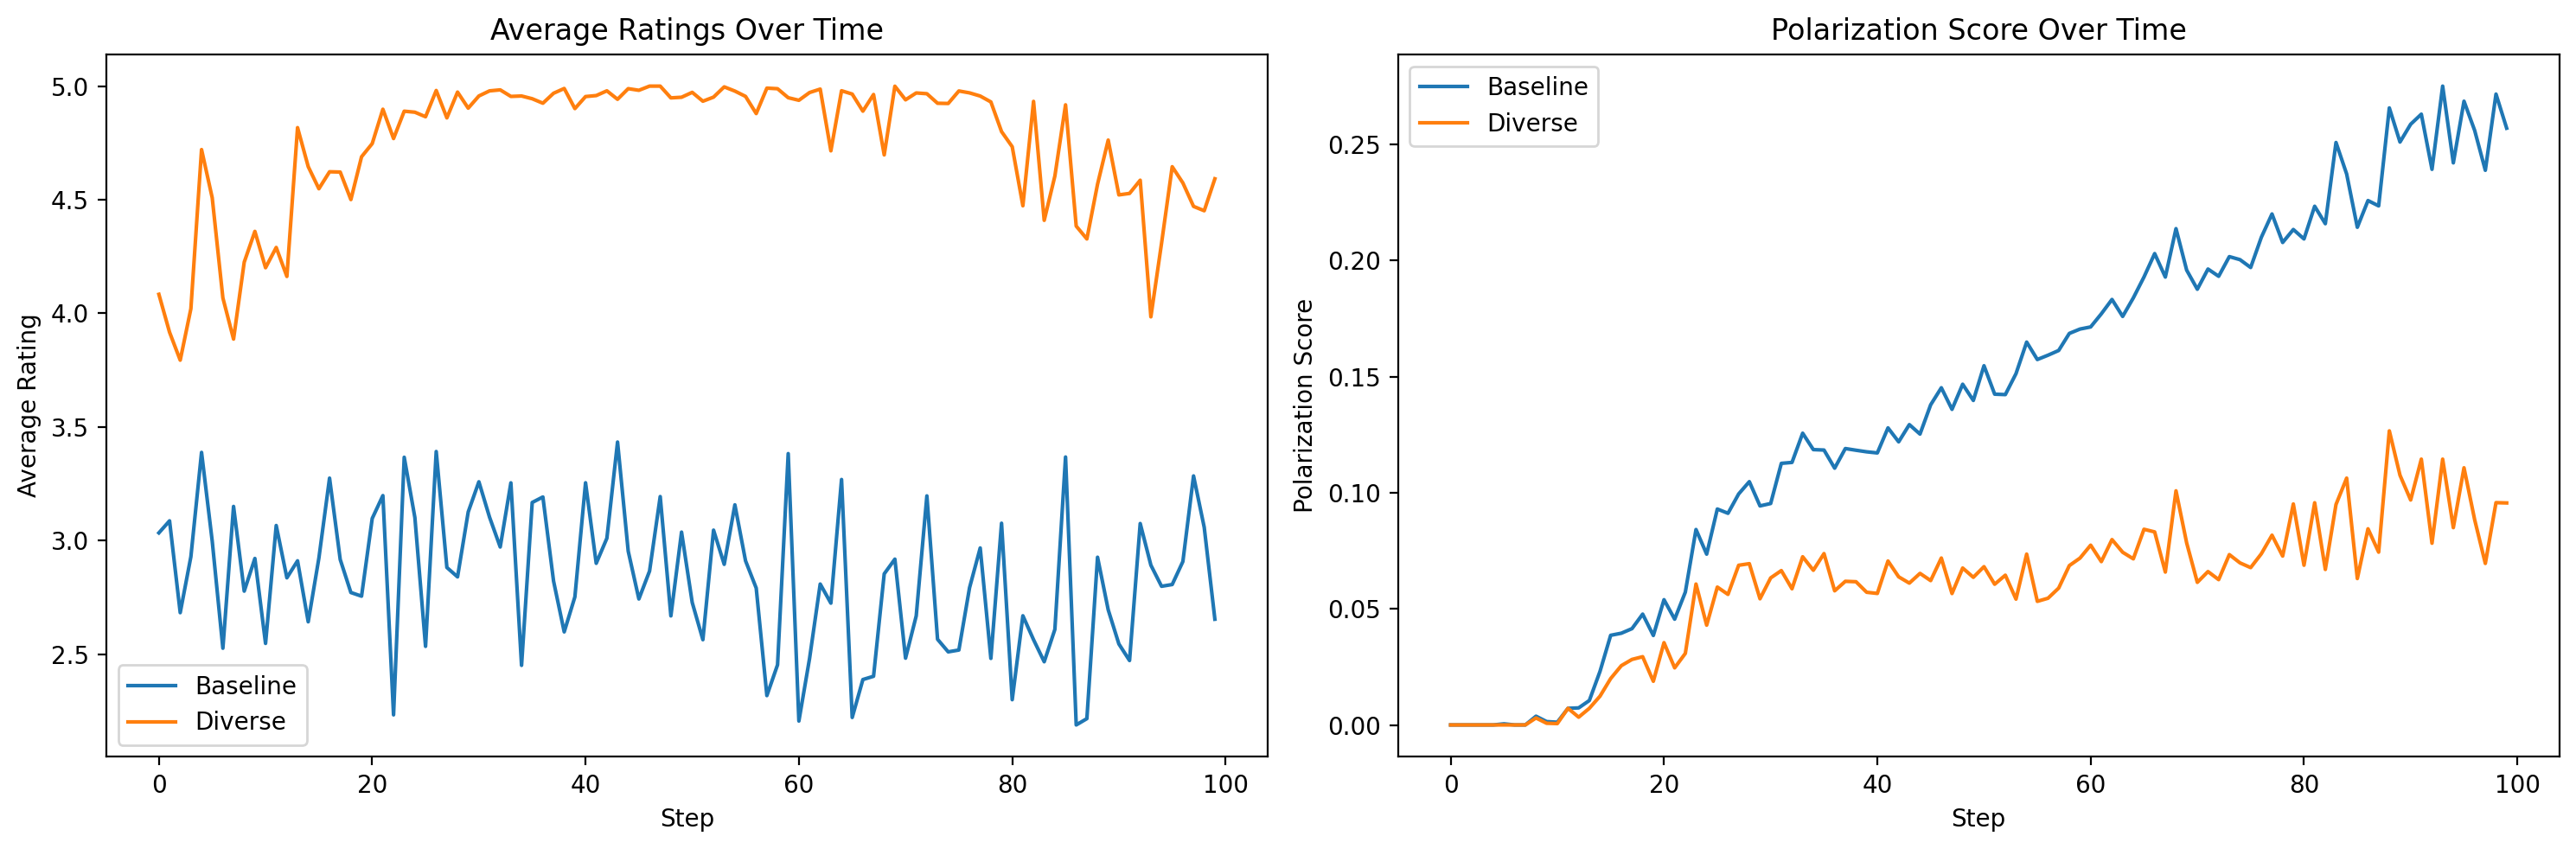

In [32]:
def run_experiment4(env_params, n_steps=100):
    # Initialize environments
    env_baseline = TopicsDynamic(**env_params)
    env_diverse = TopicsDynamic(**env_params)
    
    # Initialize recommenders
    baseline_rec = surprise.SVD(**svd_model_params)
    diverse_rec = DiversityAwareSVDRecommender4()
    
    # Get initial ratings
    initial_ratings_baseline = env_baseline.get_initial_ratings()
    initial_ratings_diverse = env_diverse.get_initial_ratings()
    
    baseline_rec.fit(trainset_from_df(initial_ratings_baseline))
    diverse_rec.fit(initial_ratings_diverse)
    
    # Track metrics
    metrics = {
        'baseline': {'ratings': [], 'polarization': []},
        'diverse': {'ratings': [], 'polarization': []}
    }
    
    # Run simulation
    for t in range(n_steps):
        # Baseline simulation step
        online_users = env_baseline.get_online_users()
        recommendations = []
        for user in online_users:
            available_items = [item for item in env_baseline.all_items 
                             if item not in env_baseline.seen_items[user]]
            pred = max([baseline_rec.predict(user, item) for item in available_items],
                      key=lambda x: x.est)
            recommendations.append((pred.uid, pred.iid))
        ratings_df = env_baseline.recommend(recommendations)
        
        # Diverse simulation step
        online_users = env_diverse.get_online_users()
        recommendations = diverse_rec.recommend(env_diverse, online_users)
        ratings_df_diverse = env_diverse.recommend(recommendations)
        
        # Update metrics
        metrics['baseline']['ratings'].append(ratings_df['rating'].mean())
        metrics['diverse']['ratings'].append(ratings_df_diverse['rating'].mean())
        
        # Calculate polarization for both
        baseline_polarization = diverse_rec.calculate_polarization_score(env_baseline, online_users)
        diverse_polarization = diverse_rec.calculate_polarization_score(env_diverse, online_users)
        
        metrics['baseline']['polarization'].append(baseline_polarization)
        metrics['diverse']['polarization'].append(diverse_polarization)
        
    return metrics

# Run experiment
experiment_params = {
    'a': 1,
    **topics_dynamic_params
}
metrics = run_experiment4(experiment_params)

plt.figure(figsize=(15, 5))

# Plot ratings
plt.subplot(1, 2, 1)
plt.plot(metrics['baseline']['ratings'], label='Baseline')
plt.plot(metrics['diverse']['ratings'], label='Diverse')
plt.title('Average Ratings Over Time')
plt.xlabel('Step')
plt.ylabel('Average Rating')
plt.legend()

# Plot polarization
plt.subplot(1, 2, 2)
plt.plot(metrics['baseline']['polarization'], label='Baseline')
plt.plot(metrics['diverse']['polarization'], label='Diverse')
plt.title('Polarization Score Over Time')
plt.xlabel('Step')
plt.ylabel('Polarization Score')
plt.legend()

plt.tight_layout()
plt.show()

🔵 **Discussion**:

The implementation demonstrates a novel approach to balancing rating performance with diversity preservation:
1. Multi-armed strategy allows exploration of different recommendation sets
2. Lookahead helps predict polarization effects before committing to recommendations
3. Weighted scoring balances immediate satisfaction with long-term diversity

The results show that the multi-armed lookahead strategy outperforms the baseline SVD recommender in terms of rating performance and polarization.

However, the lookahead approach is computationally expensive, and the results are not always better than the baseline.

The challenges we expect to encounter if the lookahead approach would be used in a realistic setting is that it is computationally expensive, and the results are not always better than the baseline.


Finally, describe briefly the challenges you expect to encounter if your lookahead approach would be used in a realistic setting (in which you would not be able to a simulator to correctly anticipate the outcomes of recommending at the next step).

🔵 **Answer**:

1. Computational cost: Running multiple simulations for each recommendation would be expensive at scale
2. Accuracy of lookahead: Real user behavior is more complex and harder to predict than our simulation
3. Parameter tuning: Finding optimal weights for rating vs. polarization would require extensive A/B testing
4. Cold start: The strategy requires sufficient historical data to make meaningful predictions
5. Real-time constraints: The multi-armed approach might be too slow for real-time recommendations